# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich
___


### Question 2 Classification Outline

1: Data Pre-Processing 
   a. Preprocessing data
   b. Data Exploration
   c. Merging with Ransac Data with our merged_data frame

2: Making this into a classification problem
   a. Divide our data into specific regions that have similar temperatures
   b. Looking at distributions based on regions

3: Running the models: for Warm States
   1. Naive Bayes
   2. Logistic Regression
   3. KNN
   4. Random Forests Classifier
   5. Decision Tree Classifier
   6. Adaboost 
   7. New Model - XGBoost

4: Running the models: for Cold States
   1. New Model - XGBoost

5: Running the models: for All States
   1. New Model - XGBoost

6: Evaluation and Interpretation
   1. Recall Scores for Warm States
   2. Feature Importance for Warm, Cold, and All States

___


### Can we classify counties in historically "Warm Temperature", "Moderate Temperature", and "Cold Temperature" States as Not Outliers and Outliers ?
   -Based on our linear regression  (using RANSAC) we were able to classify counties as outliers and not outliers. In this case we want to apply that to regions who are within the same annual temperature average. 
   Target variable: The target variable for this classification problem is to classify outlier and not outlier counties. 
    (a) 1 - Outliers
    (b) 0 - Not outliers
    
We are curious to see if low temperatures anomalies lead to a decrease/no change in property prices or vice versa.


In [21]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### *1a. Preprocessing the Data*

In [22]:
#Dictionary for state codes for us to be able to merge another dataset for longitude and latitude
state_codes = {
    'AL': '01',
    'AK': '02',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}


In [23]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()
merged_data['StateFP'] = merged_data['StateAbbrv'].map(state_codes)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on=['RegionName', 'StateFP'], right_on=['NAMELSAD', 'STATEFP'])

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Changing variable name
filtered_states = merged_data
filtered_states.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)

___
### *1b. Data Exploration*

In [24]:
filtered_states_sorted = filtered_states.sort_values(by='Anomaly (1901-2000 base period)', ascending=False)

filtered_states_sorted.describe()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON
count,579894.000000,579894.000000,579894.000000,579894.000000,5.798940e+05,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,5.798940e+05,5.798940e+05,579894.000000,579894.000000
mean,298642.184163,2010.712761,6.434317,94103.848741,2.851340e+05,55.702485,1.385632,54.317547,0.891515,4.955709,22.500000,177.251586,260.126543,72.512364,37.364843,2.338742e+09,1.819740e+08,37.986718,-89.613755
std,172104.966217,5.361191,3.466285,64177.827177,2.108634e+05,17.135498,3.388082,17.099949,0.365064,1.232351,7.500006,36.994047,36.813915,8.549974,29.181675,3.703393e+09,5.523955e+08,4.615860,12.635366
min,0.000000,2000.000000,1.000000,6109.396309,5.947229e+04,-5.200000,-22.200000,1.800000,0.180000,2.890000,15.000000,60.300000,124.000000,42.300000,1.300000,5.868388e+07,9.251200e+04,25.586120,-124.210929
25%,149711.250000,2007.000000,3.000000,52879.469613,1.884248e+05,42.800000,-0.700000,41.300000,0.540000,3.980000,15.000000,150.900000,237.700000,67.100000,7.700000,1.055922e+09,1.047176e+07,34.763109,-94.888456
50%,298870.500000,2011.000000,6.000000,77205.031646,2.347503e+05,57.200000,1.300000,55.500000,0.910000,4.650000,22.500000,179.800000,262.500000,74.800000,32.450000,1.479110e+09,2.694270e+07,38.423084,-86.034263
75%,447717.750000,2015.000000,9.000000,115764.095664,3.139183e+05,70.000000,3.400000,68.800000,1.220000,5.960000,30.000000,204.400000,286.100000,80.300000,65.500000,2.206699e+09,8.116171e+07,41.355319,-81.400955
max,596365.000000,2019.000000,12.000000,915009.312632,5.178158e+06,96.200000,19.800000,91.700000,1.510000,8.550000,30.000000,254.800000,347.300000,83.500000,82.900000,5.197631e+10,1.405367e+10,48.842653,-68.666616


In [25]:
filtered_states['Average Temperature Value'].describe()

count    579894.000000
mean         55.702485
std          17.135498
min          -5.200000
25%          42.800000
50%          57.200000
75%          70.000000
max          96.200000
Name: Average Temperature Value, dtype: float64

In [26]:
filtered_states['Anomaly (1901-2000 base period)'].describe()

count    579894.000000
mean          1.385632
std           3.388082
min         -22.200000
25%          -0.700000
50%           1.300000
75%           3.400000
max          19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

We see that there are significant regional temperature differences within these particular states, meaning that it might be useful dividing states up regionally based on similarities in average temperatures. 

Comparing an area’s recent temperature to its long-term average can tell how warm or how cool the area is compared to usual. Temperature anomalies also give us a frame of reference to better compare location. So for our data we will also be labeling areas based on regional similarities. 

So it looks like after scaling our data, we would want to divide our data into 3 regions. By doing so we are able to find outliers for states that are grouped together based on similarities in average temperatures. 

Another option is to classify based on domain knowledge. 
Since we know whih specific regions have the same annual temperature in terms of climate similarities we can divide things up regionally.
I divided based on average annual temperature ranks from the NOAA data. 

---
### *1c. Merging with Linear Regression Outlier Data*


In [27]:
#merging with outlier data 
outliers = pd.read_csv('all_data_w_outliers.csv')

data = pd.merge(filtered_states, outliers[['Is_Outlier']], left_index=True, right_index=True)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_57380/3502611620.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  outliers = pd.read_csv('all_data_w_outliers.csv')


In [28]:
# # Define temperature categories
# def categorize_temperature(temperature):
#     if temperature > 65:
#         return 'Warm'
#     elif temperature > 55:
#         return 'Moderate'
#     elif temperature > 45:
#         return 'Cold'

temperature_regions = {
    'Warm all year round': ['HI', 'FL', 'LA', 'AZ', 'TX', 'MS', 'AL', 'GA', 'SC', 'CA'],
    'Moderate': ['OK', 'AR', 'NC', 'TN', 'NV', 'KY', 'VA', 'MO', 'KS', 'MD', 'DE', 'WV', 'NM', 'NJ', 'IN', 'IL', 'OR', 
                 'OH', 'WA', 'NE', 'PA', 'UT', 'RI', 'CT', 'NY', 'MA', 'IA', 'MI', 'CO'],
    'Cold': ['ID', 'SD', 'WI', 'NH', 'MT', 'VT', 'WY', 'ME', 'MN', 'ND', 'AK']
}

# Add a new column 'Temperature_Category' to data based on state abbreviations
data['Temperature_Category'] = data['StateAbbrv'].map({state: category for category, states in temperature_regions.items() for state in states})


print(data.head())

# Initialize 
label_encoder = LabelEncoder()

# Fit and transform the 'Temperature_Category' column
data['Temperature_Category_Label'] = label_encoder.fit_transform(data['Temperature_Category'])

data.drop(columns=['Temperature_Category', 'Date'], inplace=True)

# DataFrame
data.head()

#0 = Cold, 1=Moderate, 2= Warm

   Unnamed: 0        Date  Year  Month          RegionName State  \
0           0  2000-01-31  2000      1  Los Angeles County    CA   
1           1  2000-01-31  2000      1  Los Angeles County    CA   
2        1566  2000-02-29  2000      2  Los Angeles County    CA   
3        1567  2000-02-29  2000      2  Los Angeles County    CA   
4        3136  2000-03-31  2000      3  Los Angeles County    CA   

   Bottom-Tier Average Home Value Estimate  \
0                            122826.545216   
1                            122826.545216   
2                            122977.776411   
3                            122977.776411   
4                            123487.708531   

   Top-Tier Average Home Value Estimate  Average Temperature Value  \
0                         400192.738911                       52.3   
1                         400192.738911                       52.3   
2                         400660.415894                       50.6   
3                         400660.4

,Unnamed: 0,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Is_Outlier,Temperature_Category_Label
0,0,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
1,1,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
2,1566,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,49.5,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
3,1567,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,49.5,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
4,3136,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,52.1,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2


___
### 2. *Figuring out how to make this into a classification problem*

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies (did not go with this option)
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year. (did not go with this option)
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights? (did not go with this option)

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization. (ended up using MinMax Scaler and PowerTransformer)

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective. (did not follow this idea)

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value. (could not find a concise way to do this idea)

    -Outlier Classification: Using RANSAC data to classify outliers and try looking at regions vs. looking at all the states together (went with this idea)

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

#### Dropping unnecessary columns 

In [29]:
#Keep Is_Outlier 
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Is_Outlier']
data[columns_to_float] = data[columns_to_float].astype(float)

# Get column names with object data types
object_columns = data.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
data = data.drop(object_columns, axis=1)
data = data.drop(columns='geometry', axis=1)
data.drop(columns='Unnamed: 0', inplace=True)


In [30]:
#Checking if there's nulls
# your code here
pd.concat({"Number missing values":data.isnull().sum()
            , "Percentage of missing values":data.isnull().sum()*100/data.shape[0]}
            , axis=1)

nan_rows = data[data['Is_Outlier'].isna()]
nan_rows.sample(20)

data.dropna(subset=['Is_Outlier'], inplace=True)


### *2a. Divide our data into specific regions that have similar temperatures, based on average annual temperatures from NOAA data 2001 since this is where our data is starting from.*

In [31]:
# Filter the DataFrame for warm states
warm_states = data[data['Temperature_Category_Label'] == 2]

# Filter the DataFrame for moderate states
moderate_states = data[data['Temperature_Category_Label'] == 1]

# Filter the DataFrame for cold states
cold_states = data[data['Temperature_Category_Label'] == 0]

### *2b. Looking at distributions of Temperature and Housing Prices*

In [32]:
warm_states['Anomaly (1901-2000 base period)'].describe()

count    134050.000000
mean          1.252179
std           2.842373
min         -10.100000
25%          -0.500000
50%           1.200000
75%           3.000000
max          14.000000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Warm States')

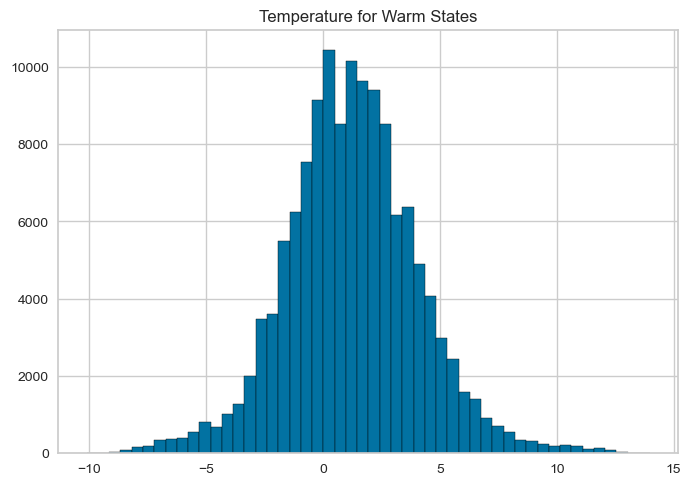

In [33]:
plt.hist(warm_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Warm States')

Warm states follow a relatively normal standard distribution. 

Text(0.5, 1.0, 'Purchase Price for Warm States')

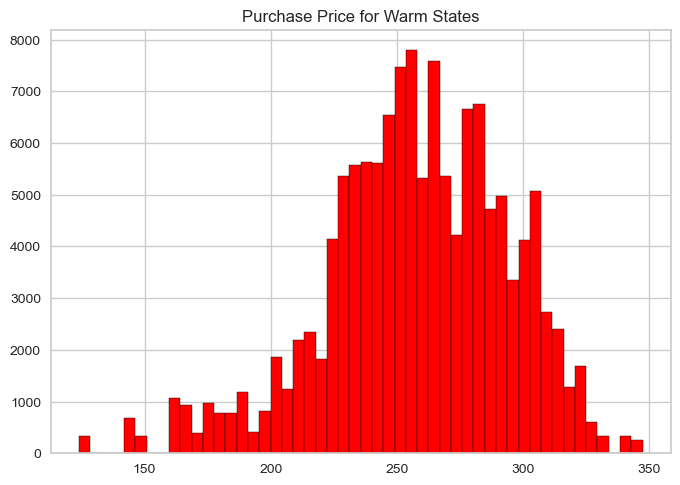

In [34]:
plt.hist(warm_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Red') 
plt.title('Purchase Price for Warm States')

In [35]:
warm_states['Purchase Price ($thou)'].describe()


count    134050.000000
mean        257.596731
std          36.667111
min         124.000000
25%         236.000000
50%         258.700000
75%         283.900000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [36]:
moderate_states['Anomaly (1901-2000 base period)'].describe()

count    327426.000000
mean          1.380002
std           3.438513
min         -14.900000
25%          -0.700000
50%           1.300000
75%           3.400000
max          17.900000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Moderate States')

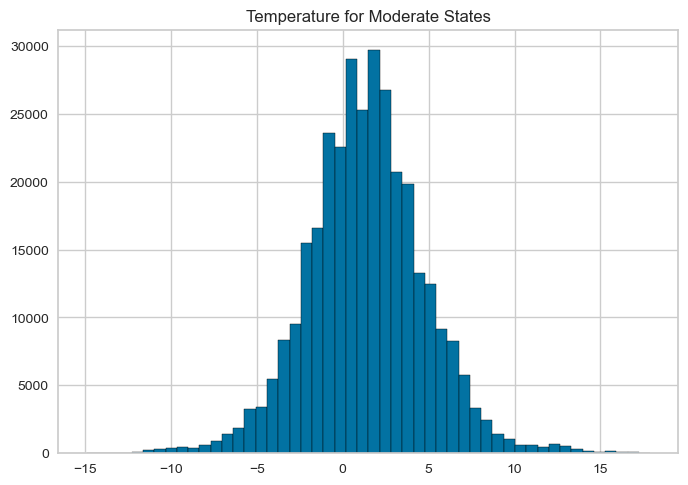

In [37]:
plt.hist(moderate_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Moderate States')

Moderate states also follow a relatively standard normal distribution. 

Text(0.5, 1.0, 'Purchase Price Moderate States')

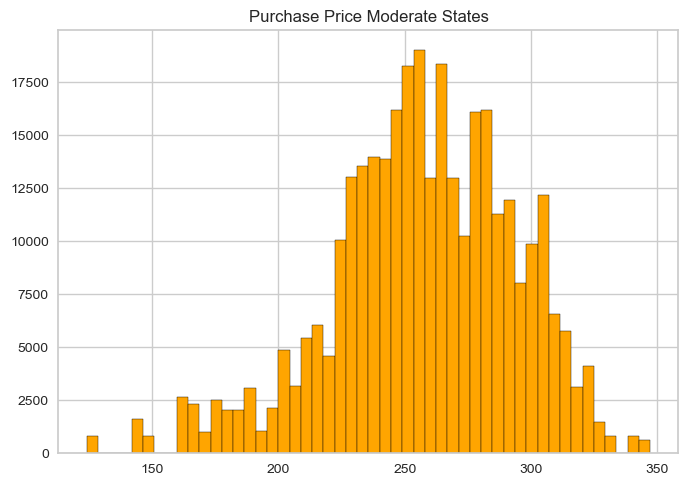

In [38]:
plt.hist(moderate_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Orange') 
plt.title('Purchase Price Moderate States')

In [39]:
moderate_states['Purchase Price ($thou)'].describe()

count    327426.000000
mean        257.035542
std          36.844478
min         124.000000
25%         235.400000
50%         257.500000
75%         283.200000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [40]:
cold_states['Anomaly (1901-2000 base period)'].describe()

count    42876.000000
mean         1.688045
std          4.048026
min        -22.200000
25%         -0.600000
50%          1.500000
75%          3.900000
max         19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Cold States')

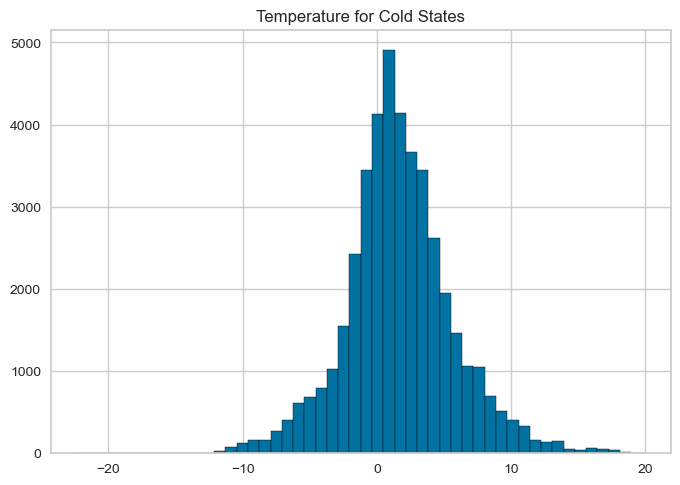

In [41]:
plt.hist(cold_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Cold States')

Colder states also follow a normal distribution with some outliers with lower values in the negatives. 

Text(0.5, 1.0, 'Purchase Price Cold States')

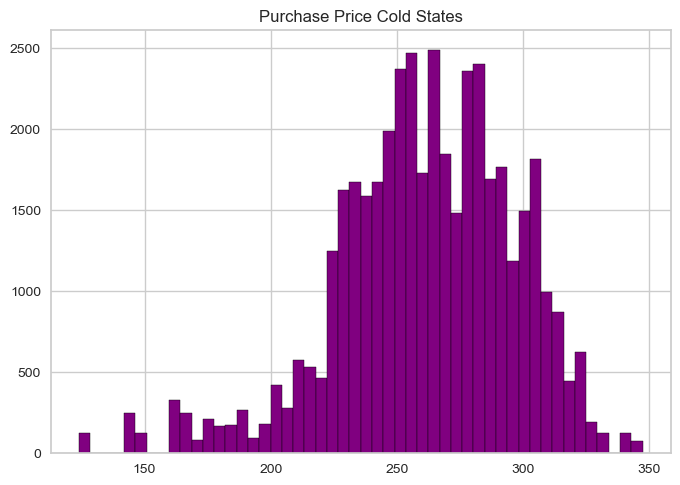

In [42]:
plt.hist(cold_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Purple') 
plt.title('Purchase Price Cold States')

In [43]:
cold_states['Purchase Price ($thou)'].describe()

count    42876.000000
mean       261.246530
std         35.930104
min        124.000000
25%        240.200000
50%        262.900000
75%        286.100000
max        347.300000
Name: Purchase Price ($thou), dtype: float64

In [44]:
warm_states.sort_values(by='Purchase Price ($thou)', ascending=False)

,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,Is_Outlier,Temperature_Category_Label
91952,2008,1,74406.172542,230239.818314,43.2,-1.1,44.3,0.41,5.65,15,141.3,347.3,49.5,6.5,1.810413e+09,1.518174e+08,33.899246,-81.266118,0.0,2
297266,2008,1,82296.187750,227858.379000,40.6,-1.3,41.9,0.41,5.65,15,141.3,347.3,49.5,6.5,7.312146e+08,8.448220e+06,34.128526,-83.203737,0.0,2
410390,2008,1,115169.285087,266104.715420,49.7,-1.4,51.1,0.41,5.65,15,141.3,347.3,49.5,6.5,1.678653e+09,1.121754e+08,30.440419,-90.727474,0.0,2
51194,2008,1,115109.111197,346800.464058,59.8,1.5,58.3,0.41,5.65,15,141.3,347.3,49.5,6.5,2.851877e+09,8.581195e+08,29.057769,-81.161792,1.0,2
301888,2008,1,106253.541180,344427.318681,48.2,-0.6,48.8,0.41,5.65,15,141.3,347.3,49.5,6.5,1.696858e+09,1.202287e+08,32.430590,-81.021627,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419426,2011,11,95387.590109,335675.571915,57.9,2.7,55.2,0.63,4.32,15,88.2,124.0,73.9,4.7,2.857618e+09,1.023176e+07,30.059953,-99.353339,1.0,2
346166,2011,11,19849.928498,104295.198544,55.9,1.4,54.5,0.63,4.32,15,88.2,124.0,73.9,4.7,9.304781e+08,8.740237e+06,32.665847,-83.425879,1.0,2
62880,2011,11,121291.046583,302315.022130,51.7,-1.7,53.4,0.63,4.32,15,88.2,124.0,73.9,4.7,2.128287e+09,2.186152e+08,38.267226,-121.939594,0.0,2
362348,2011,11,177892.151898,477550.570057,46.3,-0.7,47.0,0.63,4.32,15,88.2,124.0,73.9,4.7,9.241141e+09,1.254150e+09,40.706655,-123.926176,1.0,2


---

## *3. Classification Models and Hyperparameter Tuning for Outliers* 
Based on additional comments from Miguel, we will run model for Warm States, Cold States, and All States. Based on the models that perform the best for warm states, we will apply that model to Cold States and All States to see the differences in classification. Noted that we will try PowerTransformer and MinMaxScaler to standardize our data and see if they perform different or the same. 

 1. Naive Bayes
 2. Logistic Regression
 3. KNN
 4. Random Forests Classifier
 5. Decision Tree Classifier
 6. Adaboost 
 7. New Model - XGBoost




## Train/Test Splitting Data for *Warm States*

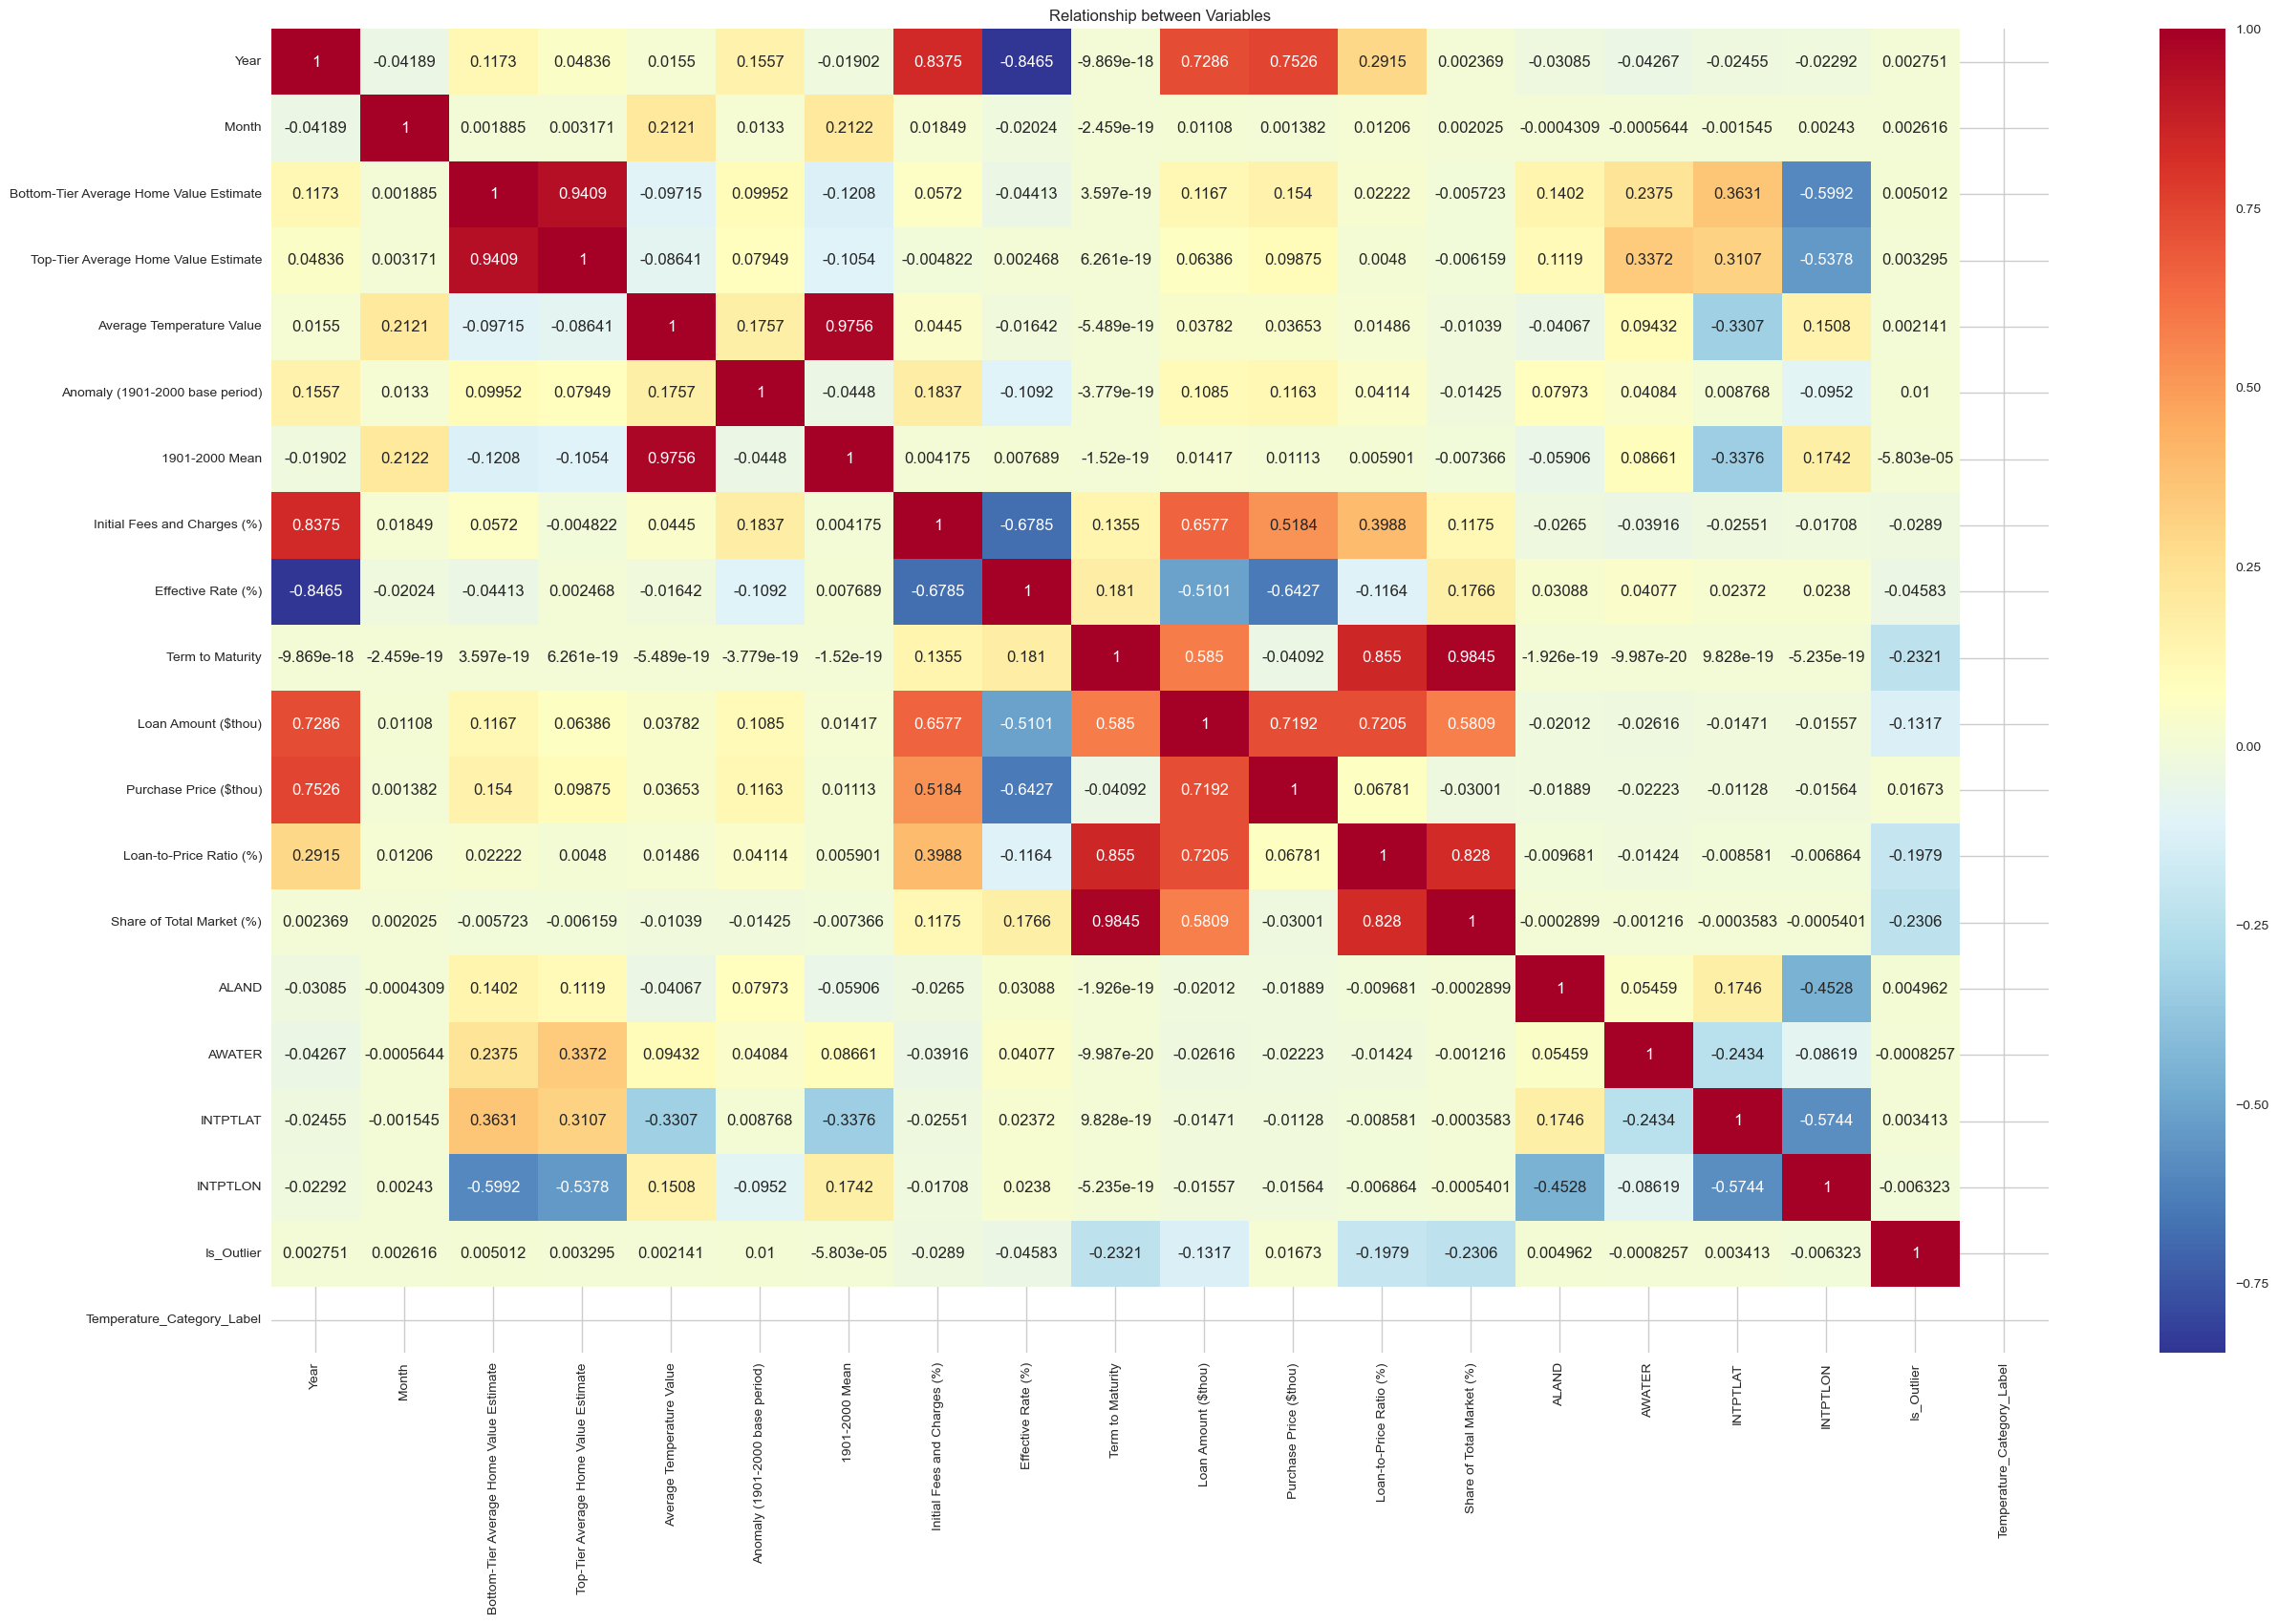

In [45]:
corr_matrix = warm_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [46]:
#Need to drop highly correlated variables 
warm_states = warm_states.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

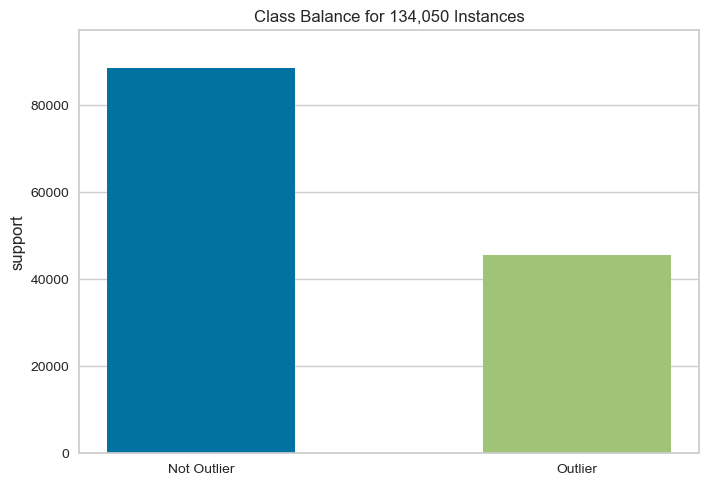

<Axes: title={'center': 'Class Balance for 134,050 Instances'}, ylabel='support'>

In [47]:
# Getting features for test and train 
labels = ["Not Outlier", "Outlier"]

visualizer = ClassBalance(labels=labels)
visualizer.fit(warm_states['Is_Outlier'])

# Show the visualizer
visualizer.show()

In [48]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the data 
X = warm_states[warm_states.columns.difference(['Is_Outlier'])]
y = warm_states['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training data
scaler.fit(X_train[columns_to_scale])

# Transforming the train and test data based on the fitted scaler
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

print(y_test)


159917    0.0
111321    0.0
94295     0.0
211430    1.0
128254    0.0
         ... 
247109    0.0
132069    0.0
347042    0.0
485258    1.0
63303     0.0
Name: Is_Outlier, Length: 33513, dtype: float64


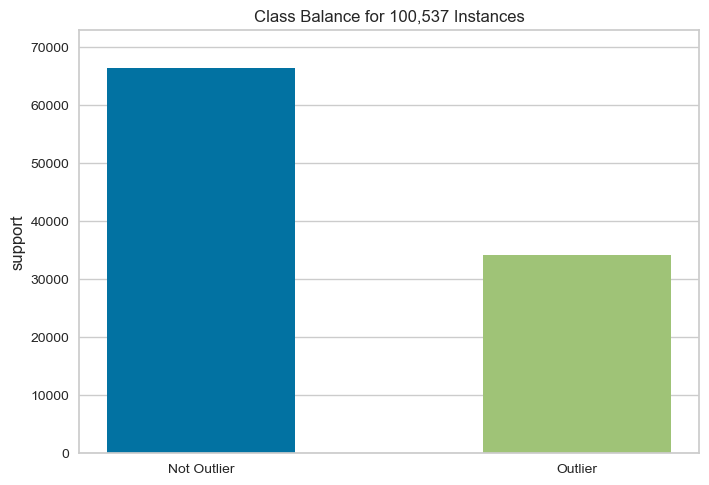

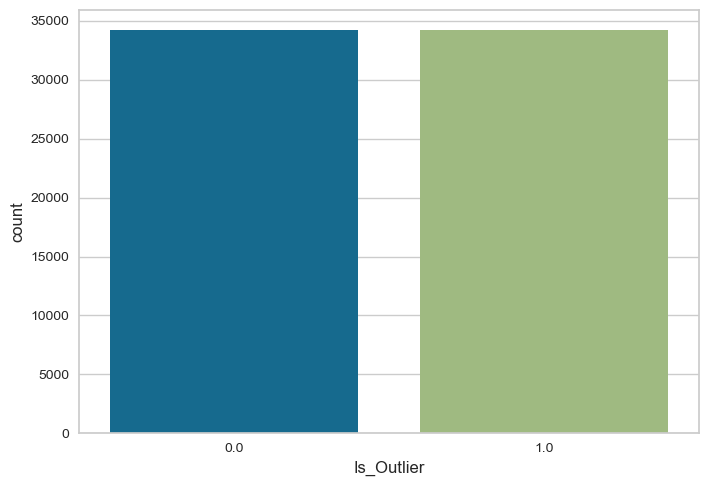

In [49]:
#We want to undersample
# your code here

visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# Visualize class balance after undersampling
sns.countplot(x=y_train_resampled, tick_label=labels)
plt.show()

Before starting, I think it is more harmful to miss labeling an outlier. Given this scenario, since we are trying to look for areas affected by temperature anomalies on housing prices, it would be more harmful in missing labeling an outlier than incorrectly labeling a not outlier as an outlier. Since recall measures the ability of a model to correctly identify all relevant instances (outliers in this case), we would want to reduce the number of false negatives. We would be able to minimize the risk of failing to identify areas affected by temperature anomalies on housing prices.



### 1. Naive Bayes

[[20397  1708]
 [10486   922]]
              precision    recall  f1-score   support

 Not Outlier       0.66      0.92      0.77     22105
     Outlier       0.35      0.08      0.13     11408

    accuracy                           0.64     33513
   macro avg       0.51      0.50      0.45     33513
weighted avg       0.55      0.64      0.55     33513



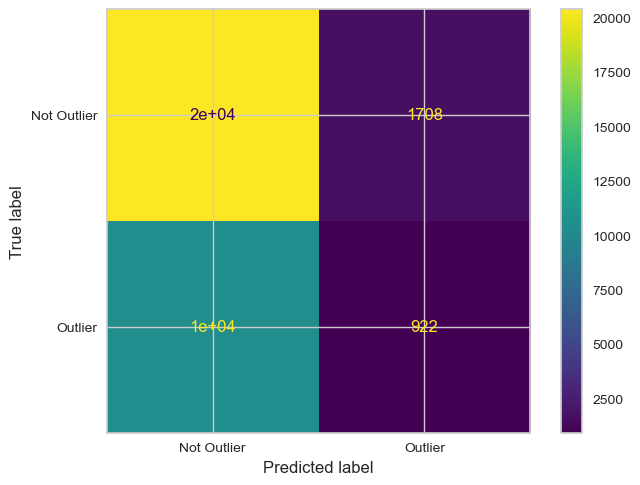

In [50]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train_resampled, y_train_resampled)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train_resampled)
y_test_pred_NB = modelNB.predict(X_test_scaled)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ["Not Outlier", "Outlier"]

#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 2. Random Forests Classifier

[[14336  7769]
 [ 3756  7652]]
              precision    recall  f1-score   support

 Not Outlier       0.79      0.65      0.71     22105
     Outlier       0.50      0.67      0.57     11408

    accuracy                           0.66     33513
   macro avg       0.64      0.66      0.64     33513
weighted avg       0.69      0.66      0.66     33513



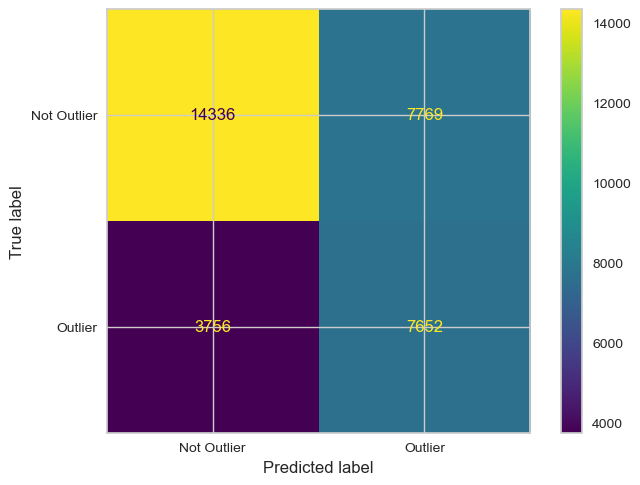

In [51]:
# your code here
model_rf = RandomForestClassifier()

#Fit the model
model_rf.fit(X_train_resampled, y_train_resampled)

#Evaluating the performance
y_pred_train_rf = model_rf.predict(X_train_resampled)
y_pred_test_rf = model_rf.predict(X_test_scaled)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rf))

#Classification Report
print(classification_report(y_test, y_pred_test_rf, target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Parameters we want to finetune: 

For Random Forests Classifier: 
n_estimators: This gives us the number of trees in the forest. Increasing the number of trees could possibly improve the model's ability to capture the complex relationships in the data, and in this case is outliers, so we will be trying different ranges of n_estimators. 
max_depth: Gives the max depth of each tree so that a deeper tree structure allows the model to capture more intricate patterns in the data. This could aid in distinguishing the outliers from normal data points.
min_samples_split: These parameters control the minimum number of samples required to split an internal node. So we would want to set higher values for these parameters to help prevent the model from overfitting to noise in the data and so preserving the meaning of the outliers.
max_features: Looks at the number of features to consider when looking for the best split. Putting bounds on the number of features considered at each split can help prevent the model from focusing too much on features that are irrelevant and  could improve its ability to identify meaningful outliers.



In [49]:
# your code here

# Parameters
parameters = {'n_estimators': [50, 100, 200],'max_depth': [10, 15, 20, 30], 'max_features': ("sqrt", "log2")}

# Initialize
model_rfc_grid_search = GridSearchCV(model_rf, param_grid=parameters, cv=5, scoring='recall_micro')

# Train
model_rfc_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_rfc_grid_search.best_params_)

{'max_depth': 20, 'n_estimators': 200}


In [52]:
# your code here
rfc_best = RandomForestClassifier(max_depth=30, max_features= 'log2', n_estimators=200)

#Fit the model
rfc_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_rfc_best = rfc_best.predict(X_train_resampled)
y_pred_test_rfc_best = rfc_best.predict(X_test)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rfc_best))

#Classification Report
print(classification_report(y_test, y_pred_test_rfc_best, target_names=labels))

[[ 9934 12171]
 [ 3632  7776]]
              precision    recall  f1-score   support

 Not Outlier       0.73      0.45      0.56     22105
     Outlier       0.39      0.68      0.50     11408

    accuracy                           0.53     33513
   macro avg       0.56      0.57      0.53     33513
weighted avg       0.62      0.53      0.54     33513



### 3. Logistic Regression

In [53]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to MinMaxScaled data 
model_lr.fit(X_train_resampled, y_train_resampled)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train_resampled)
y_test_pred_lr = model_lr.predict(X_test_scaled)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels))

[[    0 22105]
 [    0 11408]]
              precision    recall  f1-score   support

 Not Outlier       0.00      0.00      0.00     22105
     Outlier       0.34      1.00      0.51     11408

    accuracy                           0.34     33513
   macro avg       0.17      0.50      0.25     33513
weighted avg       0.12      0.34      0.17     33513



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

The C parameter is the regularization parameter. So, in this model, we want lower values of C increase the regularization strength, which can help prevent overfitting. Since we are dealing with outlier detection, we want to prevent overfitting so the model can generalize well to unseen outliers. We also want to experiment with class weights since we want to classify outliers well, so the class_weight parameter assigns higher weights to the minority class which is the outliers, we want the model to pay more attention to identifying these events, so can see how the model performs with varying degrees of emphasis on outliers. Decided to use saga for the solver parameter since liblinear works well with smaller datasets, and our dataset is large and saga can handle L1 regularization effectively. 

In [35]:
#Parameters we want to look at 
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'solver': ['saga'],  
    'penalty': ['l1', 'l2'],  
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]  
}

# Initialize a GridSearchCV object
model_lr = LogisticRegression(random_state=seed, max_iter=10000) 
model_lr_grid_search = GridSearchCV(model_lr, param_grid=parameters, cv=5, scoring='recall_micro')

# Train the GridSearchCV
model_lr_grid_search.fit(X_train_resampled, y_train_resampled)

#  Print the best parameters
print(model_lr_grid_search.best_params_)

# Save the best model into a separate variable
model_lr_grid_search_finetuned = model_lr_grid_search.best_estimator_

# Evaluating model fit
train_accuracy_lr = model_lr_grid_search_finetuned.score(X_train_resampled, y_train_resampled)
test_accuracy_lr = model_lr_grid_search_finetuned.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy_lr)
print("Test Accuracy:", test_accuracy_lr)

{'C': 0.001, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'}
Train Accuracy: 0.5
Test Accuracy: 0.34040521588637246


              precision    recall  f1-score   support

 Not Outlier       0.00      0.00      0.00     22105
     Outlier       0.34      1.00      0.51     11408

    accuracy                           0.34     33513
   macro avg       0.17      0.50      0.25     33513
weighted avg       0.12      0.34      0.17     33513



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

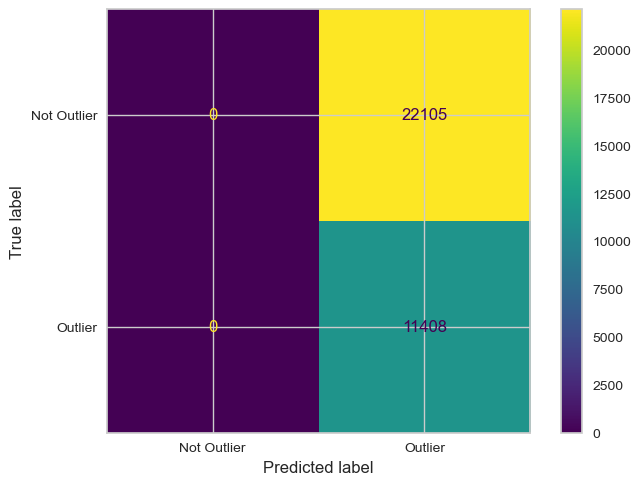

In [54]:
# your code here
lr_best = LogisticRegression(C=0.001, penalty='l1', solver="saga")
lr_best.fit(X_train_resampled, y_train_resampled)
y_pred_best_lr_test = lr_best.predict(X_test_scaled)
y_pred_best_lr_train = lr_best.predict(X_train_resampled)

conf_matrix_best_lr = confusion_matrix(y_test, y_pred_best_lr_test)

#Classification Report
print(classification_report(y_test, y_pred_best_lr_test, target_names=labels))

cm = confusion_matrix(y_test, y_pred_best_lr_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

### 5. Ada Boost Classifier

[[12984  9121]
 [ 3913  7495]]
              precision    recall  f1-score   support

 Not Outlier       0.77      0.59      0.67     22105
     Outlier       0.45      0.66      0.53     11408

    accuracy                           0.61     33513
   macro avg       0.61      0.62      0.60     33513
weighted avg       0.66      0.61      0.62     33513



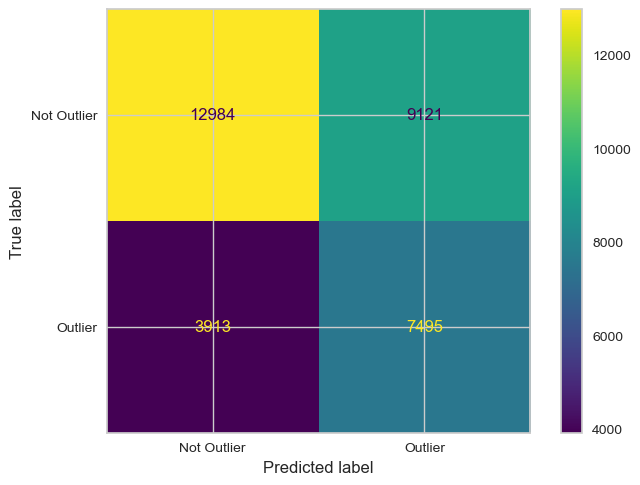

In [55]:
model_abc = AdaBoostClassifier()

#Fit the model
model_abc.fit(X_train_resampled, y_train_resampled)

#Predictions
y_pred_train_abc = model_abc.predict(X_train_resampled)
y_pred_test_abc = model_abc.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred_test_abc))

#Classification report
print(classification_report(y_test, y_pred_test_abc , target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

For adaboost, we want to look at parameters learning rate, n_estiators, algorithm and scale_pos_weight. Based on the definitions that we know, smaller learning rate requires more weak learners, which is higher n_estimators, to achieve the same performance, which can improve the robustness of the model and prevent overfitting. Larger learning rate may lead to faster convergence but can also make the model more sensitive to noise. Adaboost has 2 algorithms, both are relatively the same, but SAMME.R handles continuous probability estimates and therefore can perform better at times. 

In [40]:
# your code here
parameters = {'learning_rate': [0.1, 0.5, 1.0, 2.0], 'n_estimators': [50, 100, 150, 200], 'algorithm': ['SAMME', 'SAMME.R']}

# Step 2: Initialize a GridSearchCV object by passing your abc model, parameters and cv=10
model_ada_grid_search = GridSearchCV(model_abc, param_grid=parameters, cv=5, scoring='recall_micro')

# Step 3: Train the GridSearchCV (it will build multiply models and return the best)
model_ada_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_ada_grid_search.best_params_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 150}


In [56]:
#using chosen parameters
abc_best = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_best = abc_best.predict(X_train_resampled)
y_pred_test_abc_best = abc_best.predict(X_test_scaled)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_abc_best))

#Classification Report
print(classification_report(y_test, y_pred_test_abc_best, target_names=labels))

[[12986  9119]
 [ 3917  7491]]
              precision    recall  f1-score   support

 Not Outlier       0.77      0.59      0.67     22105
     Outlier       0.45      0.66      0.53     11408

    accuracy                           0.61     33513
   macro avg       0.61      0.62      0.60     33513
weighted avg       0.66      0.61      0.62     33513



### 6. New Model: XGBoost

[[18460  3645]
 [ 8563  2845]]
              precision    recall  f1-score   support

 Not Outlier       0.68      0.84      0.75     22105
     Outlier       0.44      0.25      0.32     11408

    accuracy                           0.64     33513
   macro avg       0.56      0.54      0.53     33513
weighted avg       0.60      0.64      0.60     33513



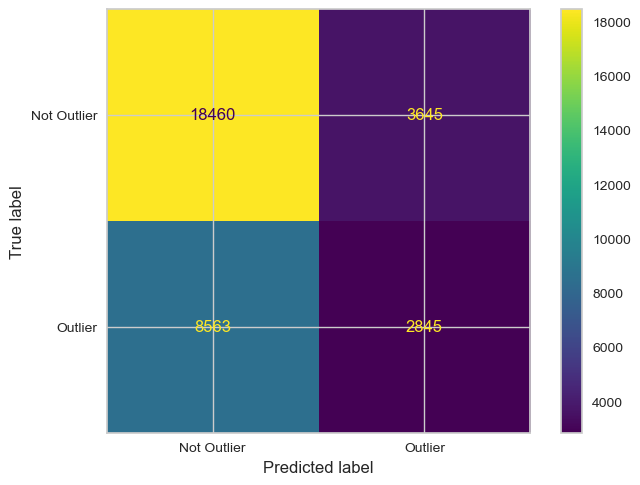

In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create the XGBoost classifier
model_xgb = XGBClassifier()

# Fit the model
model_xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_train_xgb = model_xgb.predict(X_train_resampled)
y_pred_test_xgb = model_xgb.predict(X_test)

# Confusion matrix
print(confusion_matrix(y_test, y_pred_test_xgb))

# Classification report
print(classification_report(y_test, y_pred_test_xgb, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Parameters we would want to use since XGBooster gives higher accuracy is: 
scale_pos_weight: since our data is locating outliers, we would want to set scale_pos_weight to a value greater than 1 can give more importance to the minority class (outliers), which in turn would help the model to better capture their patterns
objective: 'binary:logistic', since we want to detect outliers, we are thinking of using an objective function that penalizes errors differently for outliers and normal instances
max_depth/min_child_weight: since we want to capture outliers, we want something that can lead to deeper and more complex trees, which may better capture the patterns of outliers

In [59]:
# Define the XGBoost classifier with the chosen parameters
model_xgb = XGBClassifier()

parameters = {
    'objective': ['binary:logistic'],  
    'scale_pos_weight': [2, 5, 7, 10],  
    'max_depth': [2, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],  
    'n_estimators': [50, 100, 200]
}
# Initialize
model_xgb_grid_search = GridSearchCV(model_xgb, param_grid=parameters, cv=5, scoring='recall_micro')

# Train
model_xgb_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_xgb_grid_search.best_params_)


{'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'binary:logistic', 'scale_pos_weight': 2}


              precision    recall  f1-score   support

 Not Outlier       0.71      0.73      0.72     22105
     Outlier       0.45      0.43      0.44     11408

    accuracy                           0.63     33513
   macro avg       0.58      0.58      0.58     33513
weighted avg       0.62      0.63      0.62     33513



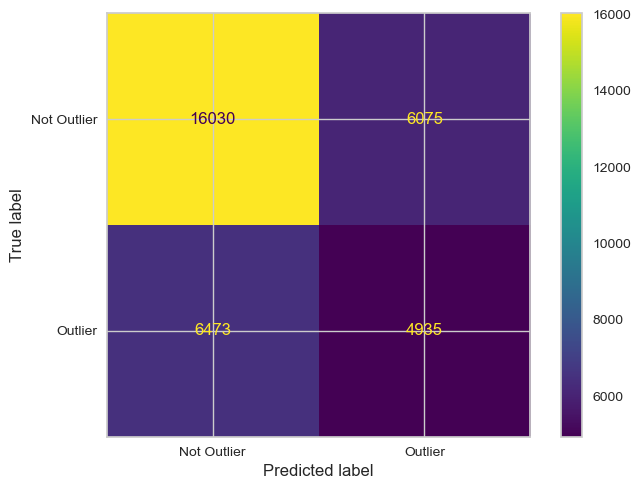

In [58]:
# your code here
xgb_best = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best = xgb_best.predict(X_train_resampled)
y_pred_test_xgb_best = xgb_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test, y_pred_test_xgb_best, target_names=labels))

Based on the model that has done best, which at the moment is AdaBoos and XGBoost, we will applt this model for cold states and all states and then look at some feature importances.

### Looking at Power Transformer
Will be trying Power transformer as another scaler method. Power transformer can reduce the impact of outliers, but they can also be sensitive to extreme values, especially if the transformation exaggerates their effect. This may be good in our case since we do want to be able to observe the features that influence the model seeing if it can classify outlier or non-outliers. 

In [59]:
#trying another scaler method
from sklearn.preprocessing import PowerTransformer

seed = 11

# standardizing the data 
X = warm_states[warm_states.columns.difference(['Is_Outlier'])]
y = warm_states['Is_Outlier']

#PowerTransformer object
power_transformer = PowerTransformer()

columns_to_transform = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the power transformer to the specified columns of the training data
power_transformer.fit(X_train[columns_to_transform])

# Transforming the train and test data based on the fitted transformer
X_train_power = X_train.copy()
X_train_power[columns_to_transform] = power_transformer.transform(X_train[columns_to_transform])

X_test_power = X_test.copy()
X_test_power[columns_to_transform] = power_transformer.transform(X_test[columns_to_transform])

print(y_test)

159917    0.0
111321    0.0
94295     0.0
211430    1.0
128254    0.0
         ... 
247109    0.0
132069    0.0
347042    0.0
485258    1.0
63303     0.0
Name: Is_Outlier, Length: 33513, dtype: float64


### XG Boost with Power Transformer

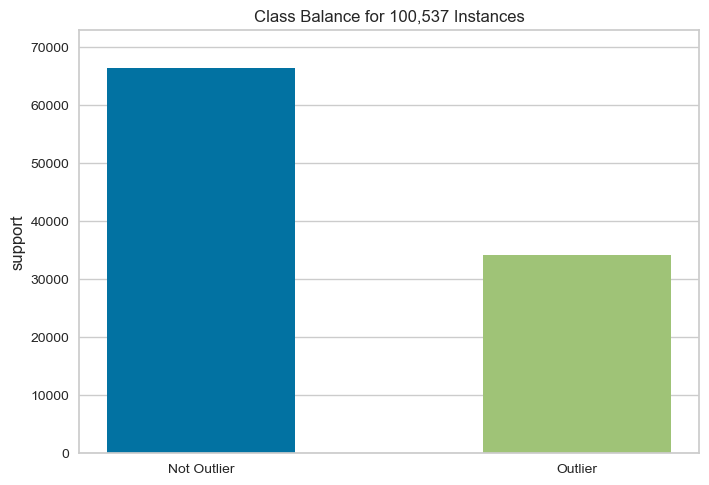

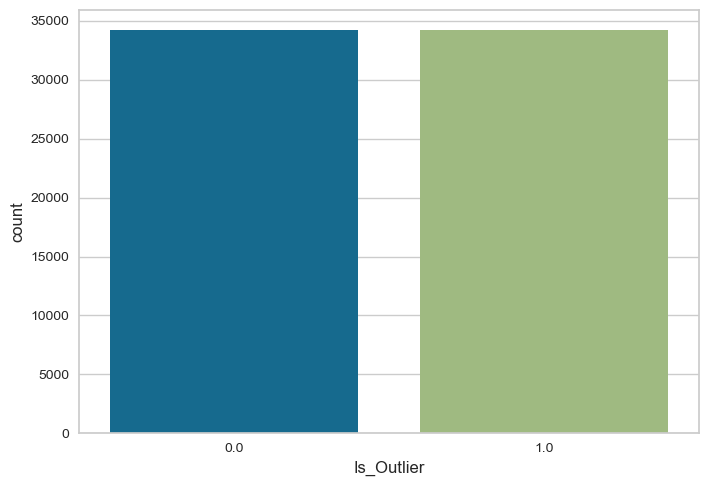

In [60]:
#We want to undersample
# your code here

visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_power_resampled, y_train_power_resampled = rus.fit_resample(X_train_power, y_train)

# Visualize class balance after undersampling
sns.countplot(x=y_train_power_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.80      0.59      0.68     22105
     Outlier       0.47      0.71      0.57     11408

    accuracy                           0.63     33513
   macro avg       0.63      0.65      0.62     33513
weighted avg       0.69      0.63      0.64     33513



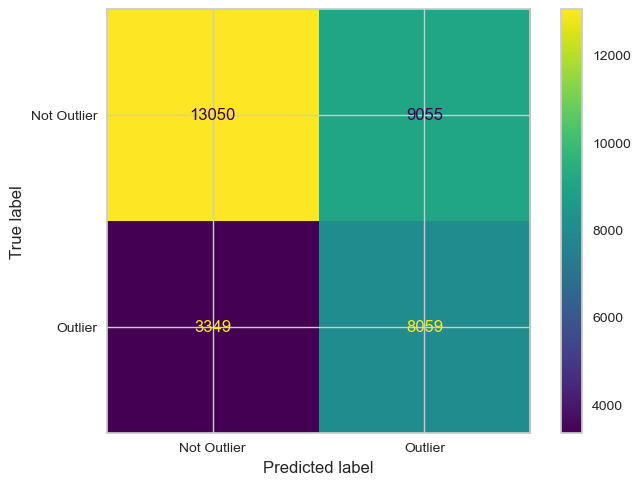

In [61]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# your code here
xgb_power = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_power.fit(X_train_power_resampled, y_train_power_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_power = xgb_power.predict(X_train_power_resampled)
y_pred_test_xgb_power = xgb_power.predict(X_test_power)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb_power)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test, y_pred_test_xgb_power, target_names=labels))

___
## 4. Train/Test Splitting Data for *Cold States*

Repeating the same steps for warm states. 

- 1. Correlation Matrix
- 2. Scaling 
- 3. Resampling
- 4. XGBooster

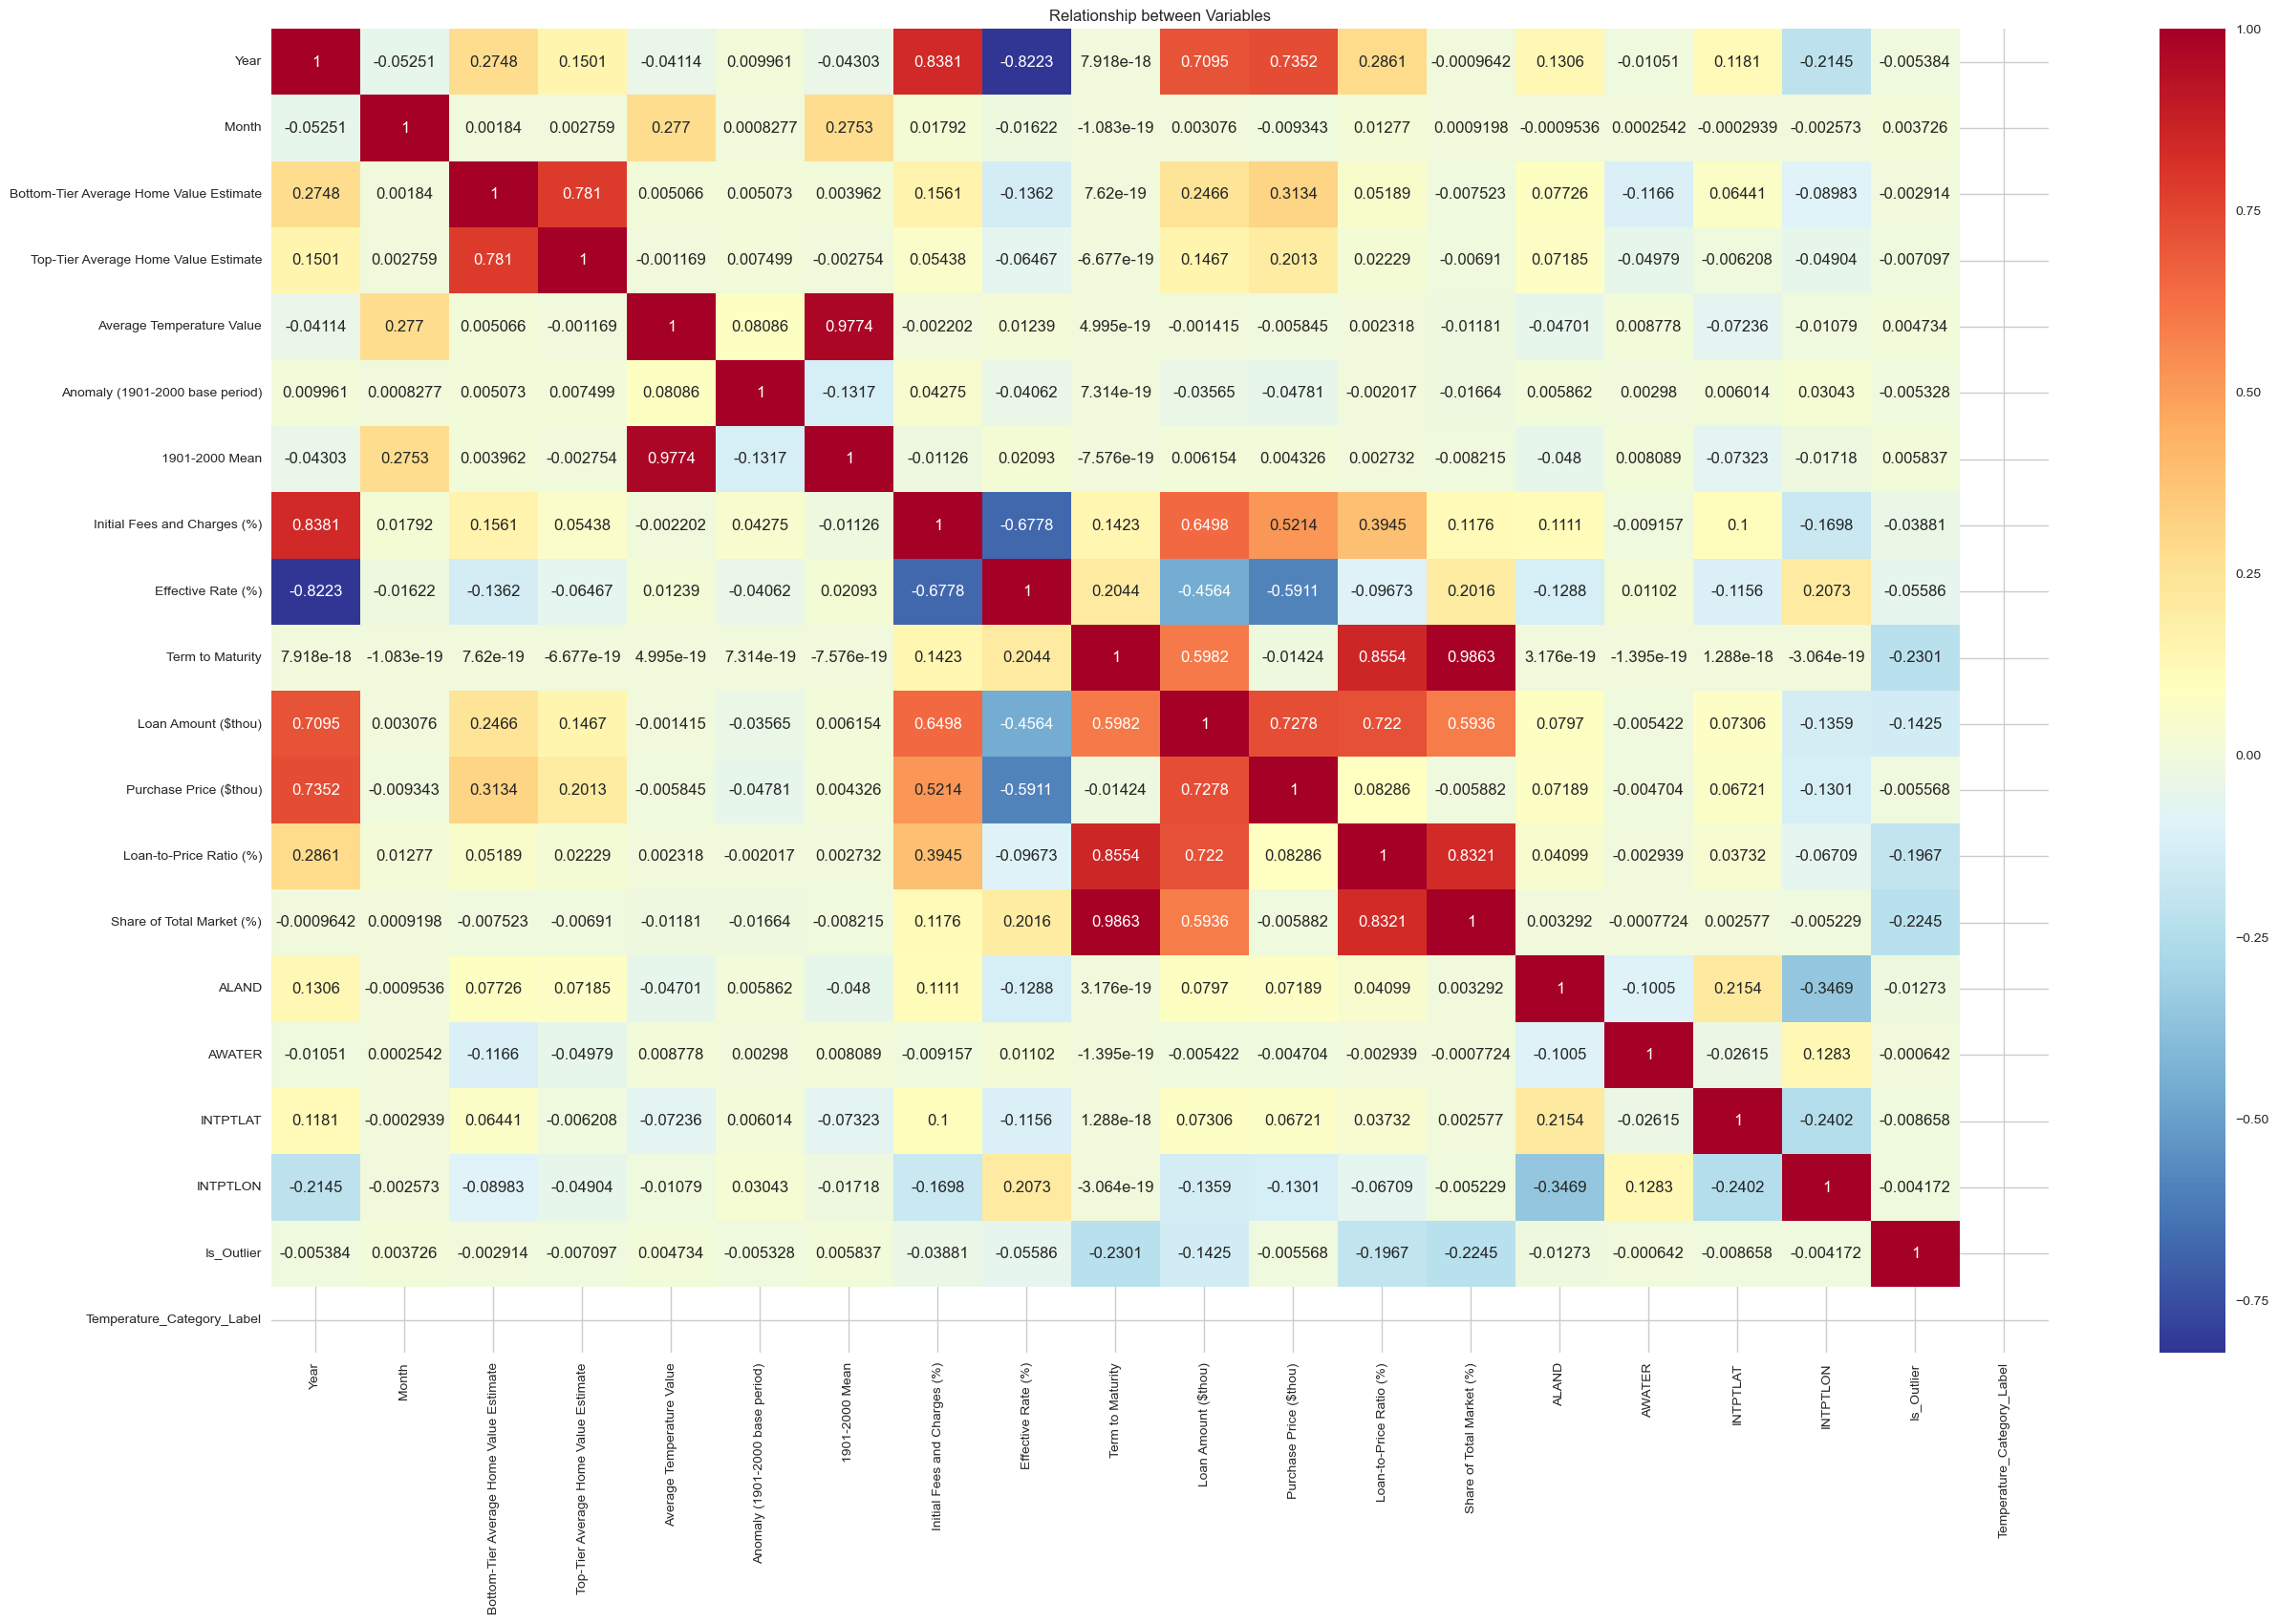

In [62]:
corr_matrix_cold = cold_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix_cold, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [63]:
#Need to drop highly correlated variables 
cold_states = cold_states.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

In [64]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the cold_states 
X = cold_states[cold_states.columns.difference(['Is_Outlier'])]
y = cold_states['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train_cold, X_test_cold, y_train_cold, y_test_cold = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training cold_states
scaler.fit(X_train_cold[columns_to_scale])

# Transforming the train and test cold_states based on the fitted scaler
X_train_cold_states = X_train_cold.copy()
X_train_cold_states[columns_to_scale] = scaler.transform(X_train_cold[columns_to_scale])

X_test_cold_states = X_test_cold.copy()
X_test_cold_states[columns_to_scale] = scaler.transform(X_test_cold[columns_to_scale])

print(y_test_cold)

422848    0.0
357187    0.0
464767    0.0
481954    0.0
392123    0.0
         ... 
457335    0.0
382844    0.0
157361    1.0
218793    0.0
129542    1.0
Name: Is_Outlier, Length: 10719, dtype: float64


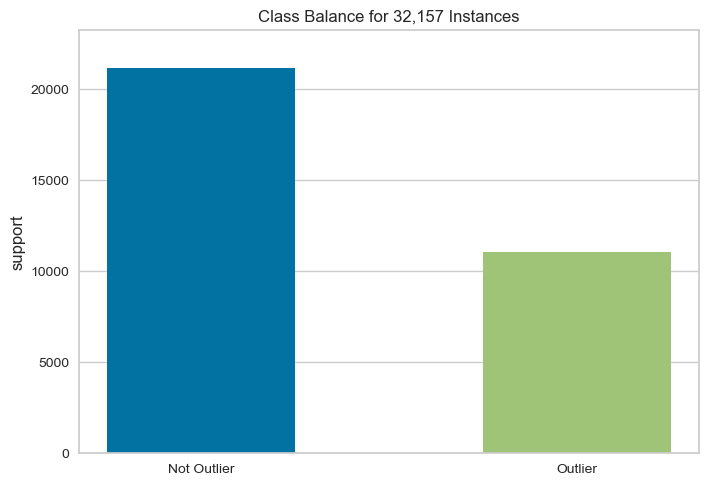

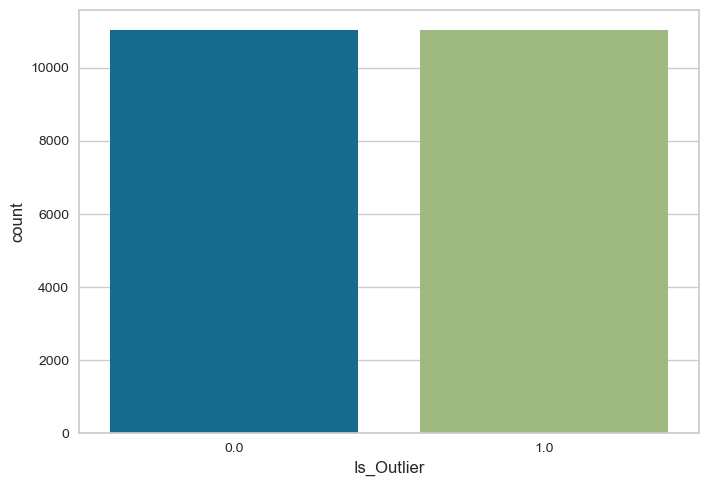

In [65]:
#We want to undersample
# your code here
labels = ["Not Outlier", "Outlier"]
visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train_cold)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_cold_resampled, y_train_cold_resampled = rus.fit_resample(X_train_cold_states, y_train_cold)

# Visualize class balance after undersampling
sns.countplot(x=y_train_cold_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.77      0.58      0.66      7049
     Outlier       0.45      0.66      0.54      3670

    accuracy                           0.61     10719
   macro avg       0.61      0.62      0.60     10719
weighted avg       0.66      0.61      0.62     10719



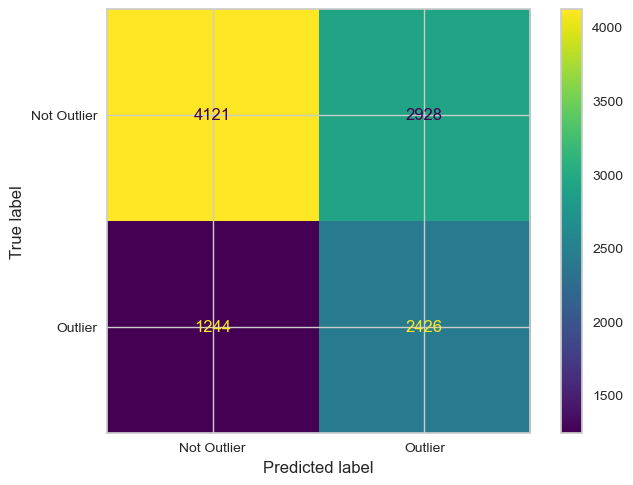

In [66]:
#using chosen parameters
abc_best_cold = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best_cold.fit(X_train_cold_resampled, y_train_cold_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_cold = abc_best_cold.predict(X_train_cold_resampled)
y_pred_test_abc_cold = abc_best_cold.predict(X_test_cold_states)

# Confusion matrix
cm = confusion_matrix(y_test_cold, y_pred_test_abc_cold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_cold, y_pred_test_abc_cold, target_names=labels))

              precision    recall  f1-score   support

 Not Outlier       0.80      0.60      0.69      7049
     Outlier       0.48      0.72      0.58      3670

    accuracy                           0.64     10719
   macro avg       0.64      0.66      0.63     10719
weighted avg       0.69      0.64      0.65     10719



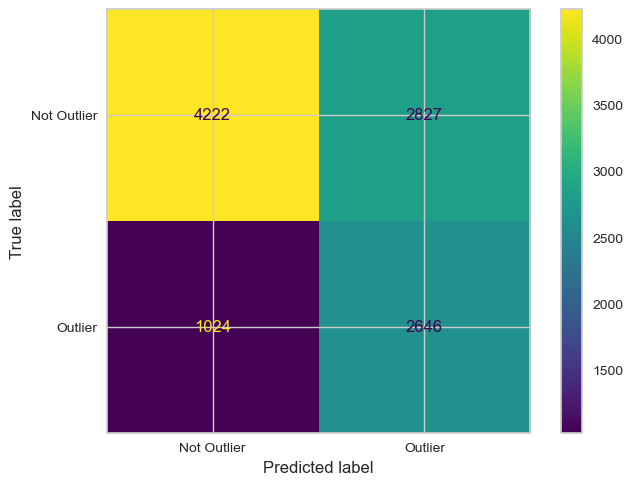

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# your code here
xgb_best_cold = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best_cold.fit(X_train_cold_resampled, y_train_cold_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best_cold = xgb_best_cold.predict(X_train_cold_resampled)
y_pred_test_xgb_best_cold = xgb_best_cold.predict(X_test_cold_states)

# Confusion matrix
cm = confusion_matrix(y_test_cold, y_pred_test_xgb_best_cold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_cold, y_pred_test_xgb_best_cold, target_names=labels))

___
## 5. Train/Test Splitting Data for *All States*

Repeating the same steps for warm and cold states. 

- 1. Correlation Matrix
- 2. Scaling 
- 3. Resampling
- 4. XGBooster

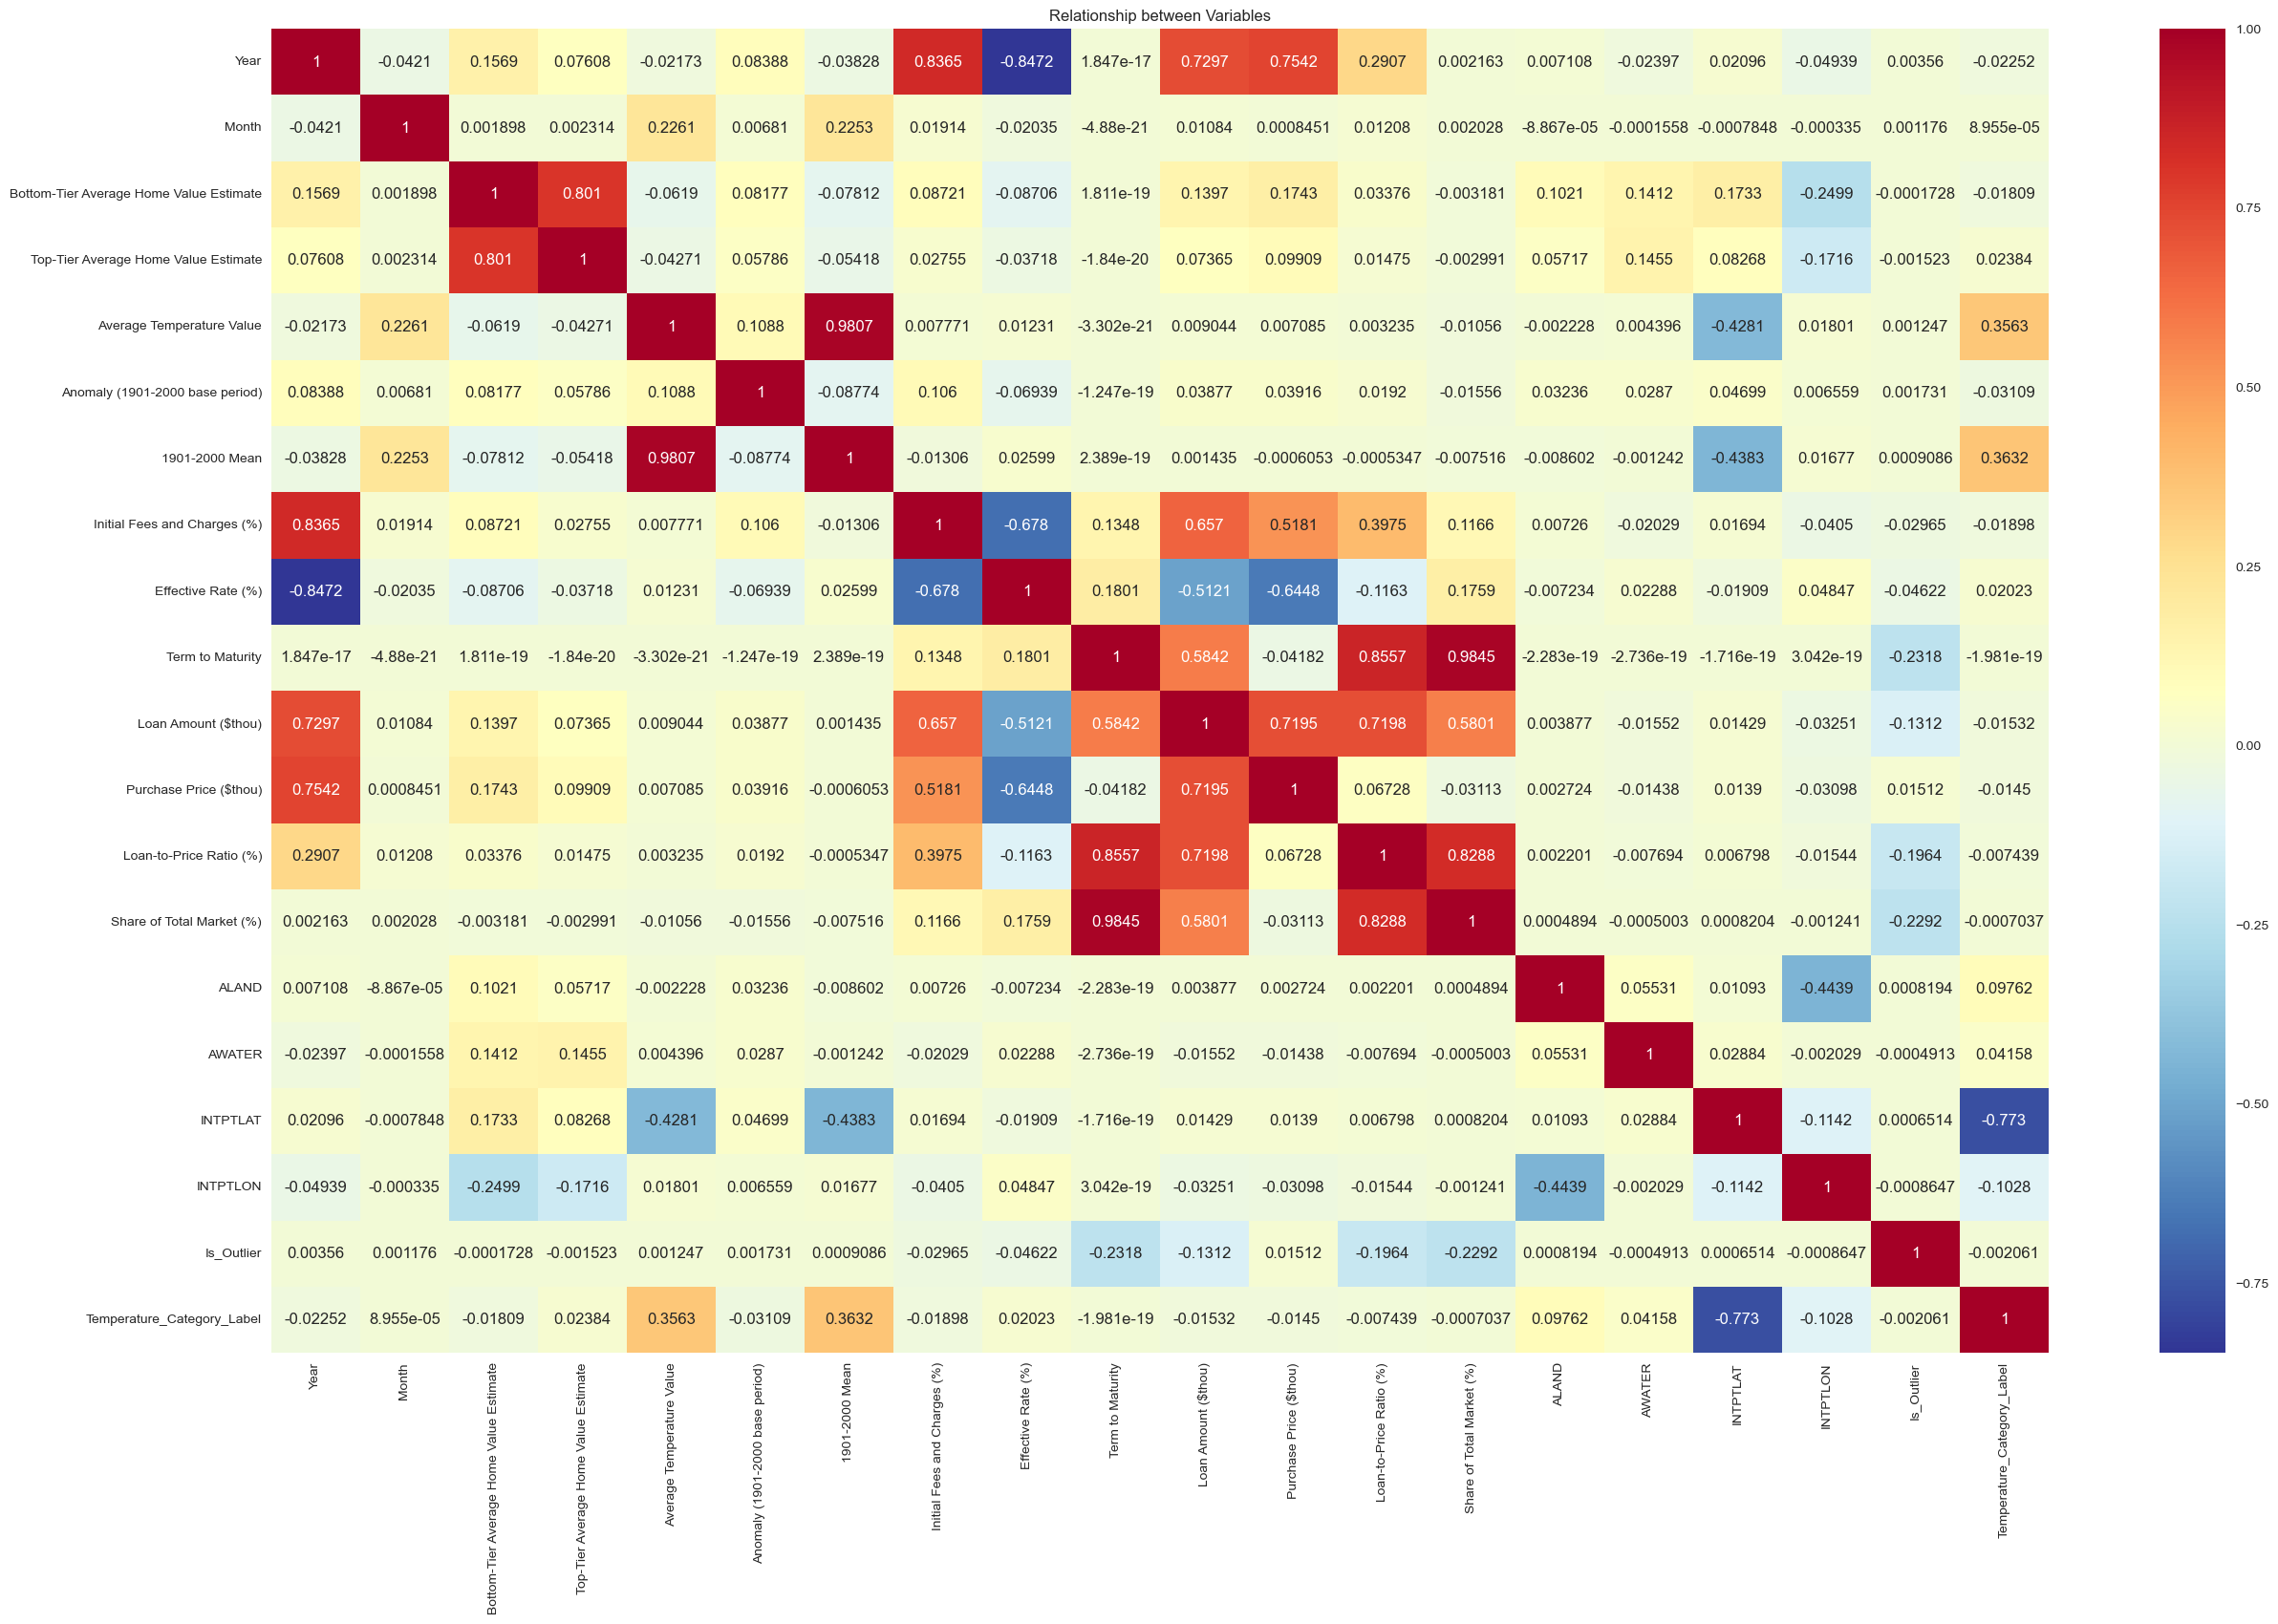

In [68]:
corr_matrix_all = data.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix_all, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [69]:
#Need to drop highly correlated variables 
data = data.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

In [70]:
from sklearn.preprocessing import MinMaxScaler

#your code here
seed=11

#standardizing the data 
X = data[data.columns.difference(['Is_Outlier'])]
y = data['Is_Outlier']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.25, random_state=seed)

# Fit the scaler to the specified columns of the training data
scaler.fit(X_train_all[columns_to_scale])

# Transforming the train and test data based on the fitted scaler
X_train_all_states = X_train_all.copy()
X_train_all_states[columns_to_scale] = scaler.transform(X_train_all[columns_to_scale])

X_test_all_states = X_test_all.copy()
X_test_all_states[columns_to_scale] = scaler.transform(X_test_all[columns_to_scale])

print(y_test_all)

417200    0.0
391878    0.0
342082    0.0
69162     0.0
463507    1.0
         ... 
115776    0.0
7306      1.0
371931    0.0
23020     0.0
506470    0.0
Name: Is_Outlier, Length: 126088, dtype: float64


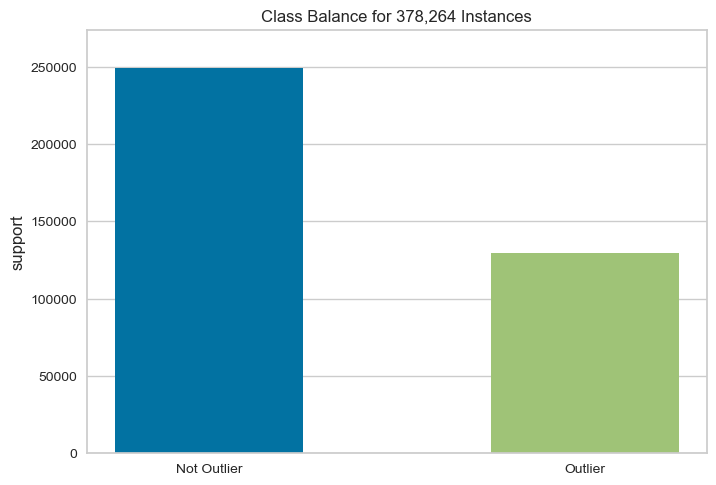

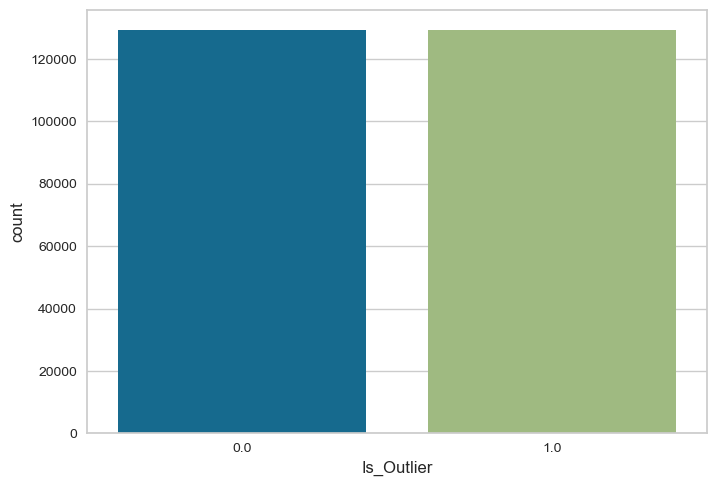

In [71]:
#We want to undersample
# your code here
labels = ["Not Outlier", "Outlier"]
visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train_all)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_all_resampled, y_train_all_resampled = rus.fit_resample(X_train_all_states, y_train_all)

# Visualize class balance after undersampling
sns.countplot(x=y_train_all_resampled, tick_label=labels)
plt.show()

              precision    recall  f1-score   support

 Not Outlier       0.77      0.59      0.66     82844
     Outlier       0.45      0.66      0.54     43244

    accuracy                           0.61    126088
   macro avg       0.61      0.62      0.60    126088
weighted avg       0.66      0.61      0.62    126088



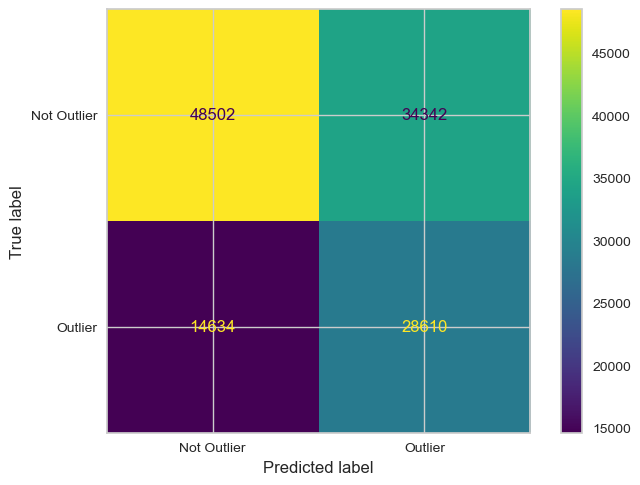

In [72]:
#using chosen parameters
abc_best_all = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 0.5, n_estimators= 150)

#Fit the model
abc_best_all.fit(X_train_all_resampled, y_train_all_resampled)

#Evaluate the model, Predictions
y_pred_train_abc_all = abc_best_all.predict(X_train_all_resampled)
y_pred_test_abc_all = abc_best_all.predict(X_test_all_states)

# Confusion matrix
cm = confusion_matrix(y_test_all, y_pred_test_abc_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_all, y_pred_test_abc_all, target_names=labels))

              precision    recall  f1-score   support

 Not Outlier       0.80      0.57      0.67     82844
     Outlier       0.47      0.73      0.57     43244

    accuracy                           0.63    126088
   macro avg       0.64      0.65      0.62    126088
weighted avg       0.69      0.63      0.64    126088



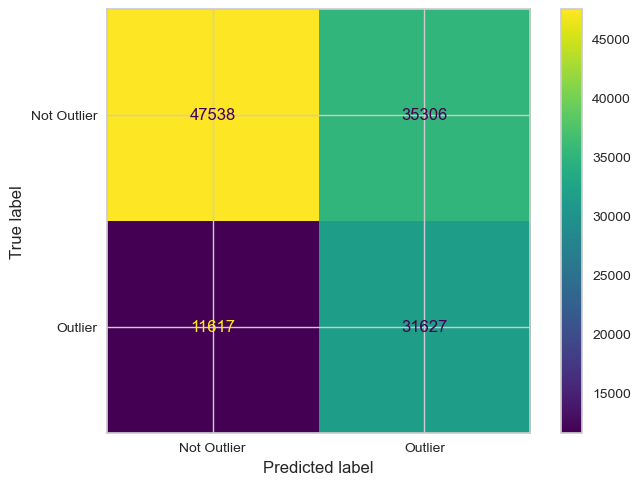

In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# your code here
xgb_best_all = XGBClassifier(max_depth=15, min_child_weight=1, n_estimators=200, objective='binary:logistic', scale_pos_weight=2)

#Fit the model
xgb_best_all.fit(X_train_all_resampled, y_train_all_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best_all = xgb_best_all.predict(X_train_all_resampled)
y_pred_test_xgb_best_all = xgb_best_all.predict(X_test_all_states)

# Confusion matrix
cm = confusion_matrix(y_test_all, y_pred_test_xgb_best_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Classification report
print(classification_report(y_test_all, y_pred_test_xgb_best_all, target_names=labels))


This model does really bad in classifying outliers, which is not the best in answering our question. 

___
## 6. Evaluation and Interpretation


#### *Warm States*

In [74]:
# your code here
# Define class labels
labels = ["Not Outlier", "Outlier"]

recall_scores_NB_7= recall_score(y_test, y_test_pred_NB, average=None)
recall_scores_lr_7 = recall_score(y_test, y_pred_best_lr_test, average=None)
recall_scores_rfc_7 = recall_score(y_test, y_pred_test_rfc_best, average=None)
recall_scores_abc_7 = recall_score(y_test, y_pred_test_abc_best, average=None)
recall_scores_xg_7 = recall_score(y_test, y_pred_test_xgb_best, average=None)

data_metric_class = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Ada Boost', 'XGBoost']
}

# Add recall scores for each class for each model to the dictionary
for i, class_name in enumerate(labels): 
    data_metric_class[class_name] = [
        recall_scores_NB_7[i],
        recall_scores_lr_7[i],
        recall_scores_rfc_7[i],
        recall_scores_abc_7[i],
        recall_scores_xg_7[i]
    ]

# Convert the dictionary to a DataFrame
df_recall_scores_class = pd.DataFrame(data_metric_class)

# Display the DataFrame
print('For Warm States')
print(df_recall_scores_class)



For Warm States
                 Model  Not Outlier   Outlier
0          Naive Bayes     0.922732  0.080820
1  Logistic Regression     0.000000  1.000000
2        Random Forest     0.449401  0.681627
3            Ada Boost     0.587469  0.656644
4              XGBoost     0.725175  0.432591


### Interpretation 

Based on model performance, XG Boost is our preferred choice since it is able to detect outliers effectively while also considering feature importances. The XGBoost model has given us a reasonable performance for detecting outliers (Outlier score of 0.432591), but it also ensures that each feature contributes significantly to the model's performance, as indicated by its feature importances (look at the figure below).

Since wanted to prioritize outliers, we wanted to maximize recall for the outlier class. XGBoost's relatively high outlier score portrayed that it performs well in identifying outliers, while its feature importances ensure that each feature contributes to this task. 


Text(0.5, 1.0, 'XGBoost')

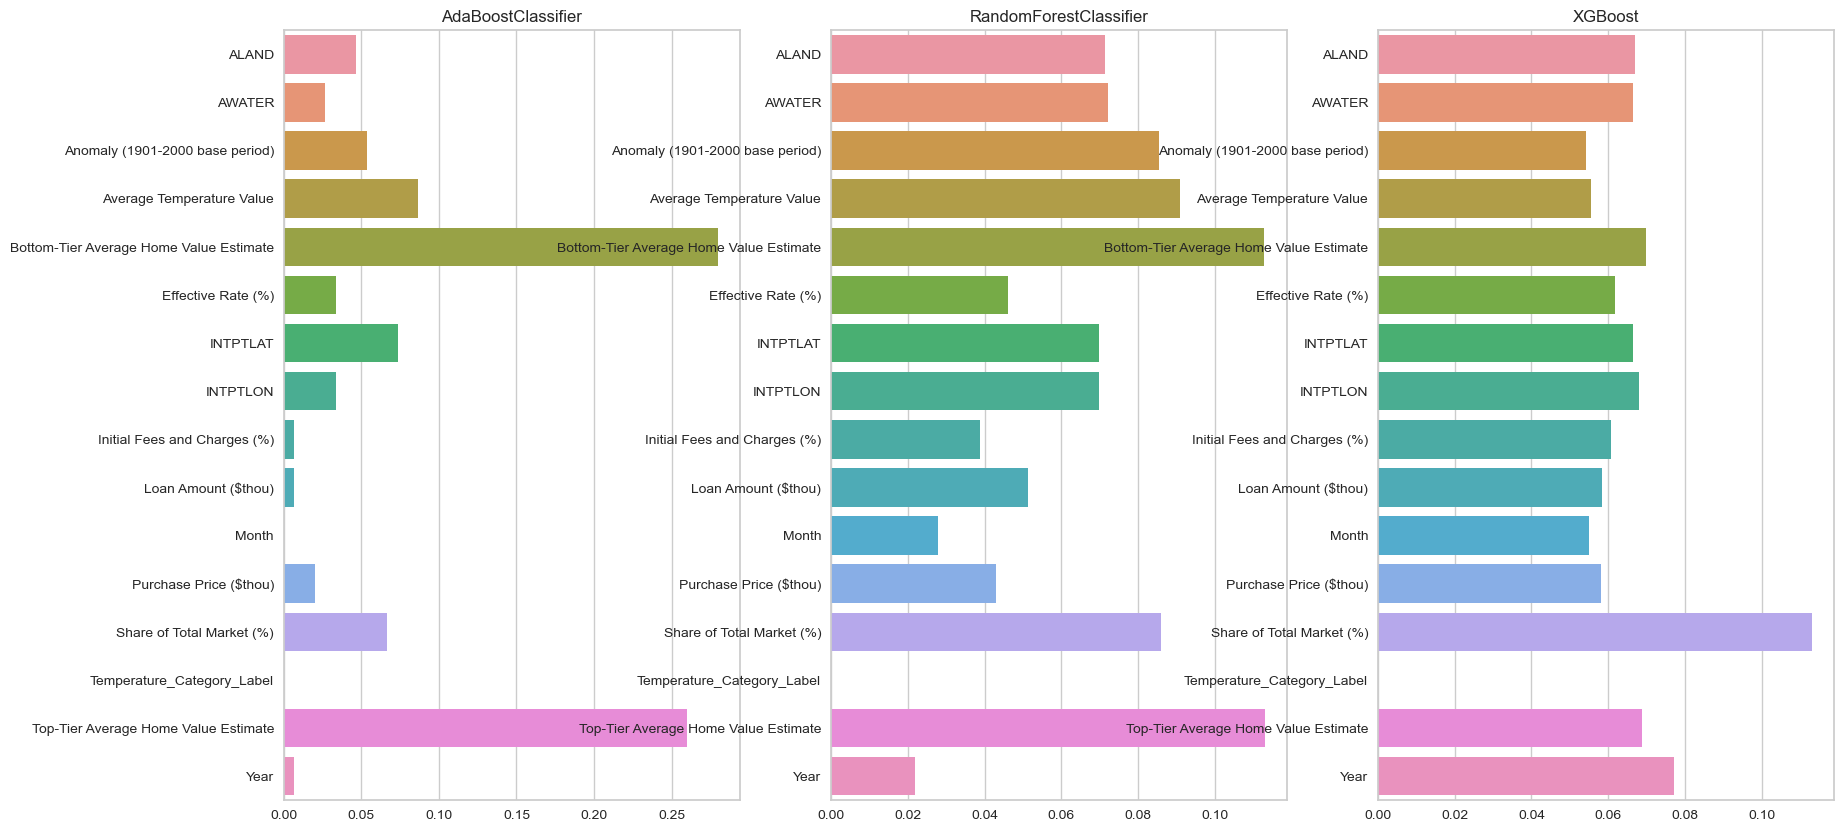

In [75]:
# your code here

fig, axes = plt.subplots(1, 3, figsize=(20,10))

# Plot 1: Warm States ABC
sns.barplot(x=abc_best.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Warm States RFC
sns.barplot(x=rfc_best.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('RandomForestClassifier')
# Plot 3: Warm States XGBoost
sns.barplot(x=xgb_best.feature_importances_, y= X.columns, ax=axes[2])
axes[2].set_title('XGBoost')

### *Cold States*

Text(0.5, 1.0, 'XGBoost')

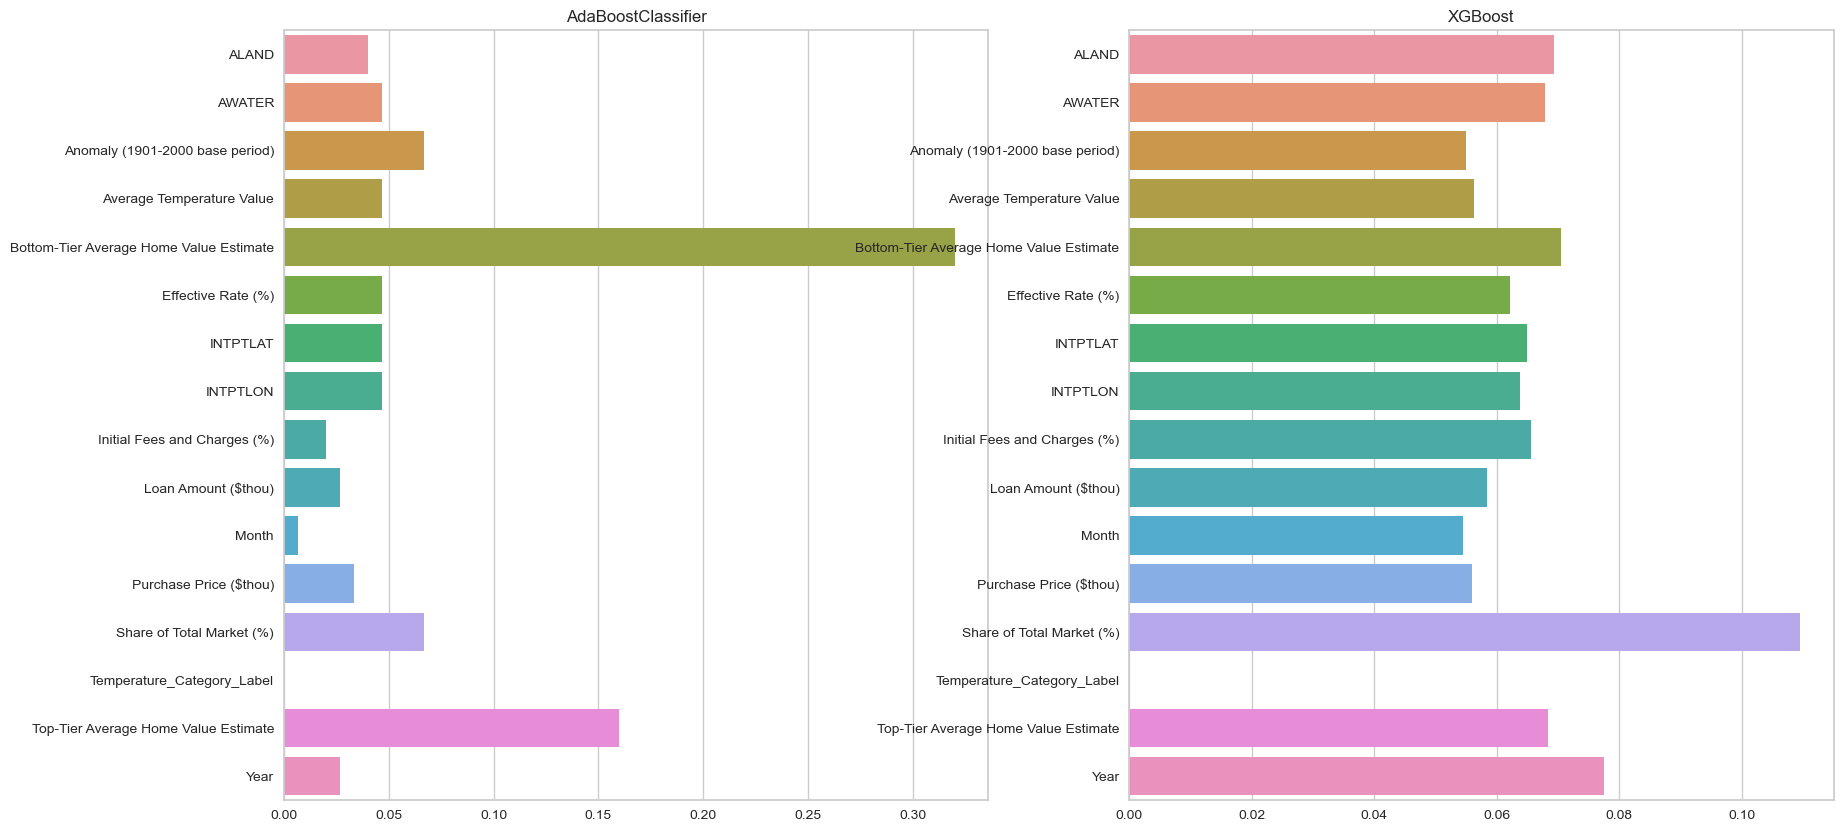

In [76]:
# your code here

fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Plot 1: Cold States ABC
sns.barplot(x=abc_best_cold.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Cold States XGBoost
sns.barplot(x=xgb_best_cold.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('XGBoost')

### *All States*

Text(0.5, 1.0, 'XGBoost')

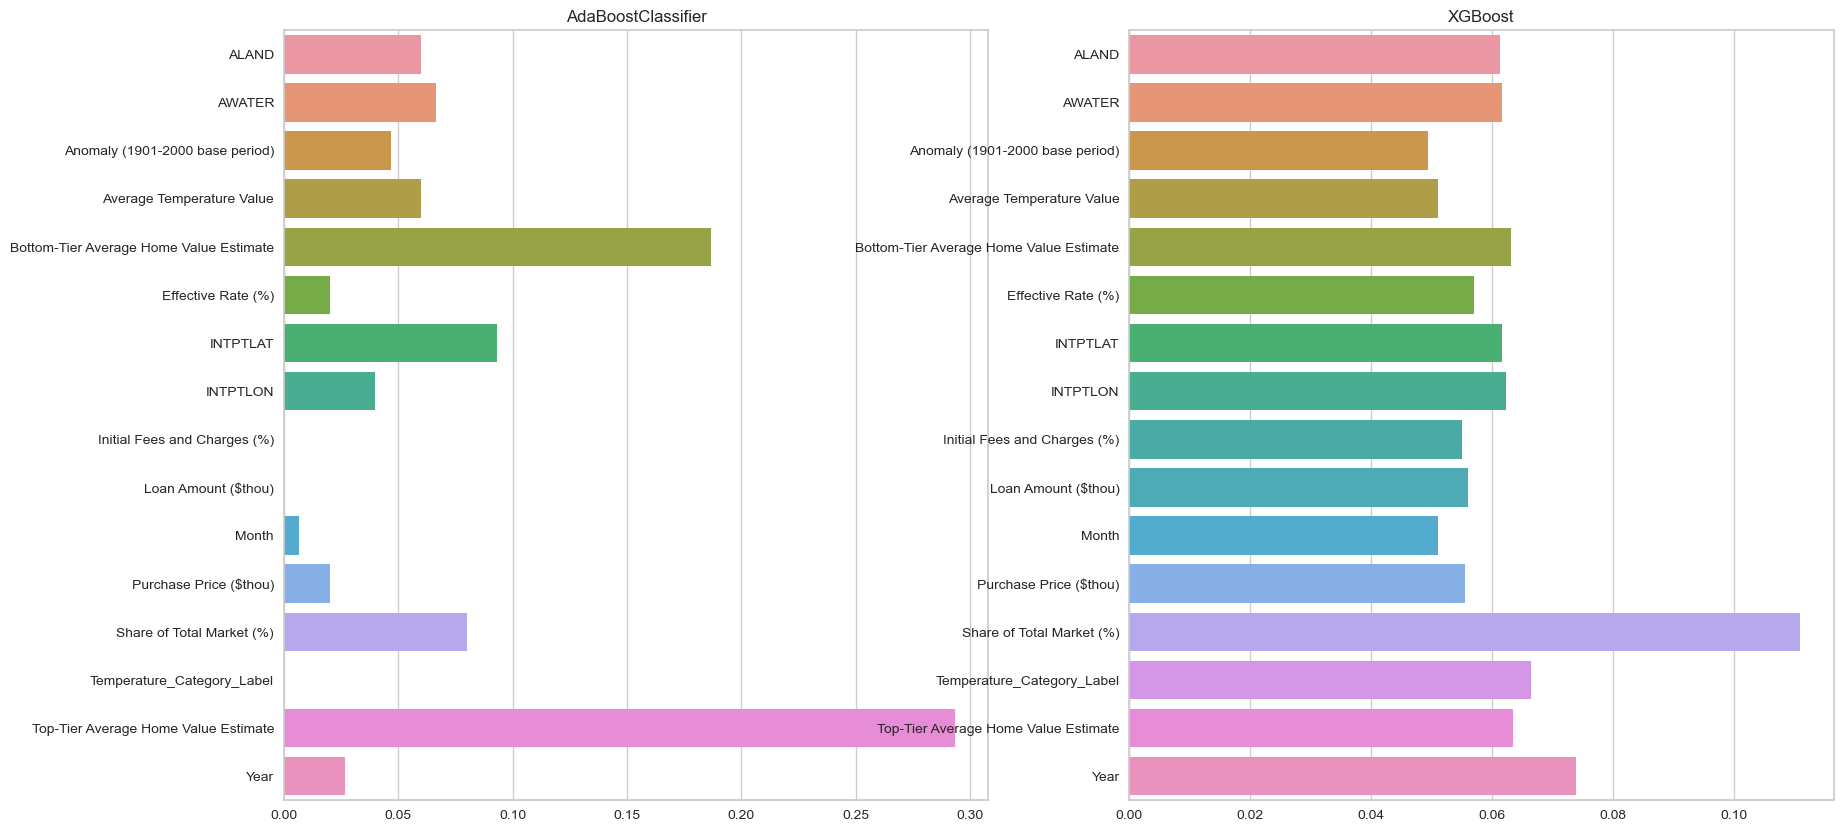

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Plot 1: Cold States ABC
sns.barplot(x=abc_best_all.feature_importances_, y= X.columns ,  ax=axes[0])
axes[0].set_title('AdaBoostClassifier')
# Plot 2: Cold States XGBoost
sns.barplot(x=xgb_best_all.feature_importances_, y= X.columns, ax=axes[1])
axes[1].set_title('XGBoost')

### Interpretation looking at Cold States and All States
We had a very big dataset, so to create a classification model we wanted to  segment it into three regions: states with warmer climates, colder climates, and a combined dataset of all states. Since XGBoost and AdaModel performed the best with warm states, XGBoost and AdaModel showed the most promising performance in warmer states, I decided to apply these models to the subset of data from colder states and then to the dataset containing all states. We still see that XG Boost does the best in including all the features even though it doesn't do the best in recall. XgBoost was the top performer by incorporating all features comprehensively. The feature importance analysis revealed that the share of the total market (%) ranked highest, while variables like temperature category label, average temperature, and purchase price value significantly influenced whether a state/county was classified as an outlier.